<a href="https://colab.research.google.com/github/scaairesearch/da_cv_fer/blob/main/experiment_model_improvement_v12_a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DA CV FER

Objective
 - Re run of V12


Observations
  - Non DANN
    - SFEW VAL:  Average loss: 0.1901, Accuracy: 246/419 (58.71%) [SOTA]
    - RACE DS:   Test / Val: Average loss: 0.5212, Accuracy: 2543/8458 (30.07%)
  - DANN
    - SFEW VAL:  Test / Val: Average loss: 0.1708, Accuracy: 213/419 (50.84%)
    - RACE DS:  Test / Val: Average loss: 0.3323, Accuracy: 2679/8458 (31.67%)

  - EWC DANN
    - SFEW VAL: Test / Val: Average loss: 0.1554, Accuracy: 233/419 (55.61%)
    - RACE DS: Test / Val: Average loss: 0.3369, Accuracy: 2631/8458 (31.11%)
  


Models
  - 23_05_wo_se_a


## Initializations
Cloning Repo, Dependencies installation, Libraries import and Config Initialization

In [1]:
# !pip install --upgrade Pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 41.9 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.3.0 which is incompatible.


### Cloning Repo, Installing dependencies

In [1]:
!git clone https://github.com/scaairesearch/da_cv_fer
import os
os.getcwd()
os.chdir('da_cv_fer')

Cloning into 'da_cv_fer'...
remote: Enumerating objects: 568, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 568 (delta 44), reused 0 (delta 0), pack-reused 483
Receiving objects: 100% (568/568), 50.41 MiB | 11.78 MiB/s, done.
Resolving deltas: 100% (318/318), done.


In [2]:
!pip install -q -r requirements.txt # -q is for quiet install
# for some reason the below does not get installed with requirements
!pip install -q opendatasets
!pip install -q facenet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.7/301.7 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 91.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 83.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 88.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.7/225.7 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [3]:
# Generic Libraries
import os
import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from tqdm import tqdm # for beautiful model training updates

import matplotlib.pyplot as plt # for plots

import time
from pathlib import Path

from copy import deepcopy
import numpy as np

from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
import pandas as pd

In [4]:
# Installs from files
from da_cv_fer.data_config import DataConfig
from da_cv_fer.ds_sfew_crop import DatasetSFEWCROP
from da_cv_fer.ds_expw_crop_image_race import EXPWIMAGECROPRACE
from da_cv_fer.utils import *
from da_cv_fer.run_config import RunConfig

### Initializing Configs

In [5]:
#initializing dataconfig, it tells us about dataset configuration and directory structure
dataconfig = DataConfig()

##  Dataset
- SFEW Dataset
- Creating Dataloader object


In [6]:
# Mounting Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Creating Dataloader

In [7]:
sfew = DatasetSFEWCROP()
sfew_train_loader, sfew_val_loader = sfew.get_dataloader()
print(f' length of SFEW dataset : {len(sfew_train_loader.dataset)}')

 self.BASE_PATH -dataset, 
 self.EXTRACT_DIR-dataset/sfew,
 self.ZIP_FILE_PATH - dataset/SFEW_2.zip 
Directory dataset/sfew created successfully.
No files (including zip file) found in dataset/sfew.Copying file
Starting File copying from /content/gdrive/MyDrive/CV_FER/dataset/SFEW_2.zip to dataset/sfew
File copied successfully from /content/gdrive/MyDrive/CV_FER/dataset/SFEW_2.zip to dataset/sfew
Initiating extraction of dataset/sfew/SFEW_2.zip to dataset/sfew
...completed for dataset/sfew/SFEW_2.zip
dataset/sfew/Train Surprise.zip Surprise
...completed for dataset/sfew/Train/Surprise.zip
dataset/sfew/Train Angry.zip Angry
...completed for dataset/sfew/Train/Angry.zip
dataset/sfew/Train Neutral.zip Neutral
...completed for dataset/sfew/Train/Neutral.zip
dataset/sfew/Train Fear.zip Fear
...completed for dataset/sfew/Train/Fear.zip
dataset/sfew/Train Disgust.zip Disgust
...completed for dataset/sfew/Train/Disgust.zip
dataset/sfew/Train Sad.zip Sad
...completed for dataset/sfew/Train/Sad.

### Example Images

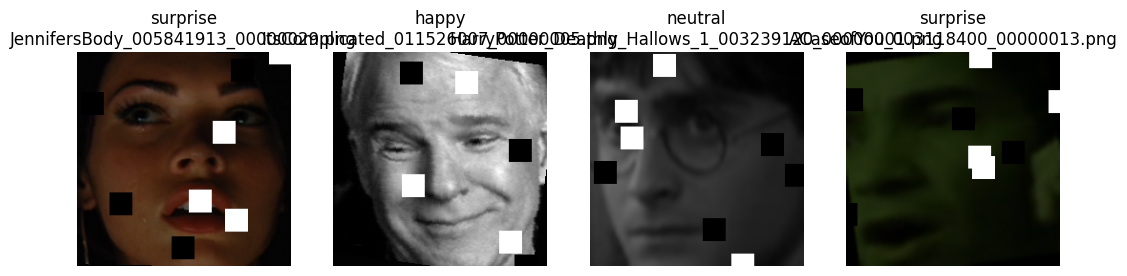

In [ ]:
show_batch(sfew_train_loader,sfew.labels,4, normalized = False)

In [8]:
sfew_loader = {'name': 'sfew',
               'train':sfew_train_loader,
               'val':sfew_val_loader
               }
data_loader = {'source' : sfew_loader}
source_name = data_loader['source']['name']

## Model Performance Metrics

In [9]:
#TODO: Move to Utils

labels_map={0:"Angry",
            1:"Disgust",
            2:"Fear",
            3:"Happy",
            4:"Sad",
            5:"Surprise",
            6:"Neutral"}

def performance_metric(model,
                       device,
                       data_loader):
    model = model.to(device)
    model.eval() # evaluation mode

    # variables to track loss and accuracy
    test_loss = 0.0
    correct = 0
    true_labels = []
    predicted_labels = []

    # Disable gradient updation
    with torch.no_grad():
        # Iterate over each batch and fetch images and labels from the batch
        for batch_idx, batch in enumerate(data_loader):
          images, labels = batch[0].to(device), batch[1].to(device)

          class_output,_,_  = model((images*255)) # forward pass, output = {class}
          true_labels.extend(labels.argmax(dim=1).cpu().numpy())
          predicted_labels.extend(class_output.argmax(dim=1).cpu().numpy())
    # print(f'true labels - {true_labels}')
    # print(f'predicted labels - {predicted_labels}')

    true_labels = [labels_map[int_label] for int_label in true_labels]
    predicted_labels= [labels_map[int_label] for int_label in predicted_labels]

    # Compute accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    print("Accuracy:", accuracy)

    # Compute precision
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    print("Precision:", precision)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    class_names = list(labels_map.values())
    cm_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
    print("Confusion Matrix:")
    print(conf_matrix)
    print(cm_df)

    # Generate classification report
    class_report = classification_report(true_labels, predicted_labels)
    print("Classification Report:")
    print(class_report)

    return true_labels, predicted_labels, accuracy, precision, cm_df, class_report



## Model Initialization

### Model_V12
- based on v8
- including dann
- including grl
- without SE


In [10]:

import torch
import torch.nn as nn
from torch.autograd import Function
import torch.nn.functional as F


class Vgg_vd_face_sfew_dag(nn.Module):

    def __init__(self):
        super(Vgg_vd_face_sfew_dag, self).__init__()
        self.meta = {'mean': [129.186279296875, 104.76238250732422, 93.59396362304688],
                     'std': [1, 1, 1],
                     'imageSize': [224, 224, 3]}
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_1 = nn.ReLU()
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_1 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_1 = nn.ReLU()
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_2 = nn.ReLU()
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_3 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_1 = nn.ReLU()
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_2 = nn.ReLU()
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_3 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.fc6 = nn.Conv2d(512, 4096, kernel_size=[7, 7], stride=(1, 1))
        self.relu6 = nn.ReLU()
        self.fc7 = nn.Linear(in_features=4096, out_features=4096, bias=True)
        self.relu7 = nn.ReLU()
        self.fc8 = nn.Linear(in_features=4096, out_features=7, bias=True)

    def forward(self, data):
        x1 = self.conv1_1(data)
        x2 = self.relu1_1(x1)
        x3 = self.conv1_2(x2)
        x4 = self.relu1_2(x3)
        x5 = self.pool1(x4)
        x6 = self.conv2_1(x5)
        x7 = self.relu2_1(x6)
        x8 = self.conv2_2(x7)
        x9 = self.relu2_2(x8)
        x10 = self.pool2(x9)
        x11 = self.conv3_1(x10)
        x12 = self.relu3_1(x11)
        x13 = self.conv3_2(x12)
        x14 = self.relu3_2(x13)
        x15 = self.conv3_3(x14)
        x16 = self.relu3_3(x15)
        x17 = self.pool3(x16)
        x18 = self.conv4_1(x17)
        x19 = self.relu4_1(x18)
        x20 = self.conv4_2(x19)
        x21 = self.relu4_2(x20)
        x22 = self.conv4_3(x21)
        x23 = self.relu4_3(x22)
        x24 = self.pool4(x23)
        x25 = self.conv5_1(x24)
        x26 = self.relu5_1(x25)
        x27 = self.conv5_2(x26)
        x28 = self.relu5_2(x27)
        x29 = self.conv5_3(x28)
        x30 = self.relu5_3(x29)
        x31 = self.pool5(x30)
        x32 = self.fc6(x31) # this is a conv layer, this is the output we need
        x33_preflatten = self.relu6(x32)
        x33 = x33_preflatten.view(x33_preflatten.size(0), -1)
        x34 = self.fc7(x33)
        x35 = self.relu7(x34)
        prediction = self.fc8(x35)
        return prediction


def vgg_vd_face_sfew_dag(weights_path=None, **kwargs):
    """
    load imported model instance

    Args:
        weights_path (str): If set, loads model weights from the given path
    """
    model = Vgg_vd_face_sfew_dag()
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
    return model

In [11]:
model_pretrained = vgg_vd_face_sfew_dag(weights_path="/content/gdrive/MyDrive/CV_FER/weights/vgg_vd_face_sfew_dag.pth")

In [12]:
model_pretrained

Vgg_vd_face_sfew_dag(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_1): ReLU()
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU()
  (pool1): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU()
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU()
  (pool2): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU()
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU()
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_3): ReLU()
  (pool3): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_m

In [13]:
import torch.nn as nn
import torch
from torch.autograd import Function
import torch.nn.functional as F


# class SEBlock(nn.Module):
#     def __init__(self, in_channels, reduction_ratio=16):
#         super(SEBlock, self).__init__()
#         self.avg_pool = nn.AdaptiveAvgPool2d(1)
#         self.fc = nn.Sequential(
#             nn.Linear(in_channels, in_channels // reduction_ratio),
#             nn.ReLU(inplace=True),
#             nn.Linear(in_channels // reduction_ratio, in_channels),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         batch_size, num_channels, _, _ = x.size()
#         y = self.avg_pool(x).view(batch_size, num_channels)
#         y = self.fc(y).view(batch_size, num_channels, 1, 1)
#         return x * y.expand_as(x)


class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

class DANN_VGG(nn.Module):
    def __init__(self,
                 model_pretrained = model_pretrained,
                 num_classes=7,
                 dropout_rate = 0.1,
                 ):
        super(DANN_VGG, self).__init__()
        #---------------------Feature Extractor Network------------------------#
        list_feature_extractor = list(model_pretrained.children())[:-4]

        # SE Block
        # self.se_block = SEBlock(512)
        # list_feature_extractor.insert(-15,  SEBlock(256))
        # list_feature_extractor.insert(-8,  SEBlock(512))
        # list_feature_extractor.insert(-1,  SEBlock(512))
        self.feature_extractor = nn.Sequential(*list_feature_extractor)


        # self.feature_extractor = nn.Sequential(*list(model_pretrained.children())[:-4])

        #---------------------Class Classifier------------------------#
        list_class_classifer = list(model_pretrained.children())[-4:]
        list_class_classifer.insert(2, nn.Dropout(dropout_rate))
        self.class_classifier = nn.Sequential(*list_class_classifer)



        #---------------------Domain Classifier------------------------#

        self.domain_classifier = nn.Sequential(nn.ReLU(),
                                               nn.Linear(4096, 4096),
                                               nn.Dropout(dropout_rate),
                                               nn.ReLU(),
                                               nn.Linear(4096, 2)
                                               )

        # Initialize the 4096,4096 to pre-trained
        pretrained_weights = model_pretrained.fc7.weight
        pretrained_biases = model_pretrained.fc7.bias
        with torch.no_grad():
          self.domain_classifier[1].weight.copy_(pretrained_weights)
          self.domain_classifier[1].bias.copy_(pretrained_biases)


    def forward(self, input_data, alpha = 0.0):
        features = self.feature_extractor(input_data)
        # print("features.shape......", features.shape)
        features = features.view(-1,features.size(1))
        # print("features.shape after view......", features.shape)

        reverse_features = GradientReversalFn.apply(features,alpha)

        class_output = self.class_classifier(features)
        domain_output = self.domain_classifier(reverse_features)

        return class_output, domain_output, features


In [14]:
model = DANN_VGG(model_pretrained = model_pretrained, num_classes=7)
from torchsummary import summary  #for model summary and params
print(model)

DANN_VGG(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256,

In [15]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [16]:
from torchsummary import summary
summary(model.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
# !pip install torch-summary

In [ ]:
# from torchsummary import summary
# summary(model, (3, 224, 224), col_names = ["input_size", "output_size", "num_params", "kernel_size", "mult_adds"], verbose =2 )

## Checking accuracy before fine tuning

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [17]:
model = model.to(device=device)

### Test Function

In [18]:
def get_correct_preds(prediction, labels):
    """
    Function to return total number of correct predictions
    :param prediction: Model predictions on a given sample of data
    :param labels: Correct labels of a given sample of data
    :return: Number of correct predictions
    """
    return prediction.argmax(dim=1).eq(labels.argmax(dim=1)).sum().item()

In [20]:
# def test_model_local(model, device, data_loader, mode= 'test',
#                class_loss_function = nn.CrossEntropyLoss() ):
#     model = model.to(device)
#     model.eval() # evaluation mode

#     # variables to track loss and accuracy
#     test_loss = 0.0
#     correct = 0
#     pbar = tqdm(data_loader) # putting the dataloader in progress bar


#     # Disable gradient updation
#     with torch.no_grad():
#         # Iterate over each batch and fetch images and labels from the batch
#         for batch_idx, batch in enumerate(pbar):
#         # for batch_idx, batch in enumerate(data_loader):
#             images, labels = batch[0].to(device), batch[1].to(device)

#             class_output,_,_  = model((images*255)) # forward pass, output = {class}
#             class_loss = class_loss_function(class_output,labels) # Calculate Loss

#             test_loss += class_loss.item() # sum up batch loss

#             # Sum up batch correct predictions
#             correct += get_correct_preds(class_output, labels)

#     # Calculate test loss for a epoch
#     test_loss /= len(data_loader.dataset)

#     pbar.set_description(desc= f'Test / Val: Average loss={test_loss.item(): 0,2f} Accuracy={correct}/{len(data_loader.dataset)}({100*correct/len(data_loader.dataset):0.2f}%)')


#     # print('Test / Val: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(data_loader.dataset),
#     #     100. * correct / len(data_loader.dataset)))


#     return correct, test_loss

In [21]:
def test_model_local(model, device, data_loader, mode= 'test',
               class_loss_function = nn.CrossEntropyLoss() ):
    model = model.to(device)
    model.eval() # evaluation mode

    # variables to track loss and accuracy
    test_loss = 0.0
    correct = 0


    # Disable gradient updation
    with torch.no_grad():
        # Iterate over each batch and fetch images and labels from the batch
        for batch_idx, batch in enumerate(data_loader):
            images, labels = batch[0].to(device), batch[1].to(device)

            class_output,_,_  = model((images*255)) # forward pass, output = {class}
            class_loss = class_loss_function(class_output,labels) # Calculate Loss

            test_loss += class_loss.item() # sum up batch loss

            # Sum up batch correct predictions
            correct += get_correct_preds(class_output, labels)

    # Calculate test loss for a epoch
    test_loss /= len(data_loader.dataset)

    print('Test / Val: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))


    return correct, test_loss

#### Pre fine train metric

In [22]:
correct, test_loss = test_model_local(model, device, data_loader['source']['val'], mode= 'test')
correct, test_loss

Test / Val: Average loss: 0.5606, Accuracy: 107/419 (25.54%)



(107, 0.5606391196603707)

In [23]:
true_labels, predicted_labels, accuracy, precision, conf_matrix, class_report = performance_metric(model= model,
                                                                                                   device= device,
                                                                                                   data_loader = data_loader['source']['val'], # source val loader
                                                                                                   )

Accuracy: 0.2553699284009546
Precision: 0.3124765070292672
Confusion Matrix:
[[13 23  2  9 21  5  2]
 [ 0  5  0  7  6  2  2]
 [ 3  3  4  5 14  8  6]
 [ 0  0  0 61  8  3  0]
 [ 4  6  2  6 12 10 12]
 [ 1  8  1  7 59  5  3]
 [ 0  6  3 12 14 29  7]]
          Angry  Disgust  Fear  Happy  Sad  Surprise  Neutral
Angry        13       23     2      9   21         5        2
Disgust       0        5     0      7    6         2        2
Fear          3        3     4      5   14         8        6
Happy         0        0     0     61    8         3        0
Sad           4        6     2      6   12        10       12
Surprise      1        8     1      7   59         5        3
Neutral       0        6     3     12   14        29        7
Classification Report:
              precision    recall  f1-score   support

       Angry       0.62      0.17      0.27        75
     Disgust       0.10      0.23      0.14        22
        Fear       0.33      0.09      0.15        43
       Happy      

### Reuse existing model if applicable

In [26]:
# ## from data_config import DataConfig
# dataconfig_1 = DataConfig()
# MODEL_DIR = dataconfig_1.MODEL_DIR
# target_name = "expw"
# model_name = 'non_dann_sfew_expw_23_05_wo_se.pt'

# MODEL_PATH = Path(os.path.join(MODEL_DIR, f'non_dann_{source_name}_{target_name}', model_name))

# best_model =  DANN_VGG(model_pretrained = model_pretrained, num_classes=7)  # skeleton copy

# best_model.load_state_dict(torch.load(MODEL_PATH,map_location=torch.device(device)))
# best_model.to(device)

DANN_VGG(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256,

### Train Function

#### Basic Training Function

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn.functional as F

def train_model_local(model, train_loader, criterion, optimizer, device='cuda'):
    model.to(device)
    model.train()
    # for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0

    for inputs, labels,_ in train_loader:
        inputs = inputs * 255.0  # Convert inputs from [0, 1] to [0, 255]
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs,_,_ = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        correct += get_correct_preds(outputs, labels)


    epoch_loss = running_loss / len(train_loader.dataset)
    length_dataset = len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy : {correct}/{length_dataset} Or {100. * correct / length_dataset: .2f} %')

    return



#### Training Function with LR Scheduler

In [ ]:
def train_model_local_lr(model,device, data_loader, optimizer, epoch,
                class_loss_function = nn.CrossEntropyLoss() ):
    print(f'epoch = {epoch+1}...in training function')
    model.to(device)
    model.train() # setting model to training


    pbar = tqdm(data_loader) # putting the dataloader in progress bar

    processed = 0 # to understand accuracy, used in denominator
    epoch_loss = 0.0
    correct = 0

    for batch_idx, batch in enumerate(pbar):
        batch[0] = batch[0] * 255.0  # Convert inputs from [0, 1] to [0, 255]
        images, labels = batch[0].to(device), batch[1].to(device) # batch of images and labels


        optimizer.zero_grad() # setting gradients to zero to avoid accumulation

        class_output, _ , _ = model(images) # forward pass, output = {class, domain, feature}

        class_loss = class_loss_function(class_output,labels) # Calculate Loss
        epoch_loss += class_loss.item()
        # Sum up batch correct predictions
        correct += get_correct_preds(class_output, labels)

        class_loss.backward() #backpropogation, creating gradients

        optimizer.step() # updating the params

        processed += len(images)
        curr_lr = optimizer.param_groups[0]['lr']

        pbar.set_description(desc= f'Loss={class_loss.item()} Accuracy={correct}/{processed}({100*correct/processed:0.2f}%) Epoch Avg loss={epoch_loss/processed:0.8f} LR={curr_lr:0.6f}')

    return float("{:.8f}".format(epoch_loss/processed)),  curr_lr


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Execution without Learning Rate

In [ ]:
# num_epochs=55
# for epoch in range(num_epochs):
#   train_model_local(model = model, train_loader = data_loader['source']['train'], criterion = criterion, optimizer=optimizer)
#   test_model_local(model, device, data_loader['source']['val'], class_loss_function= criterion, mode= 'test')
# print('Training finished.')

### Weighted test function

In [38]:
import torch

# Assuming train_loader is your DataLoader
all_labels = []

for batch in data_loader['source']['train']:
  all_labels.append(batch[1])



In [39]:
# Concatenate all labels into a single tensor
all_labels = torch.cat(all_labels)

# Assuming labels are one-hot encoded
all_labels_indices = torch.argmax(all_labels, dim=1)

In [40]:
# all_labels_indices

In [41]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Convert to numpy array for compatibility with compute_class_weight
all_labels_indices_np = all_labels_indices.numpy()

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(all_labels_indices_np), y=all_labels_indices_np)
class_weights = torch.tensor(class_weights, dtype=torch.float)

print(f'Class weights: {class_weights}')

Class weights: tensor([0.7539, 2.0703, 1.4821, 0.6689, 0.9058, 0.8255, 1.4177])


### Execution with LR

In [ ]:
runconfig = RunConfig()
device = runconfig.device

model = DANN_VGG(model_pretrained = model_pretrained, num_classes=7).to(device=device)
best_model = DANN_VGG(model_pretrained = model_pretrained, num_classes=7).to(device=device)

#learning rate
lr =  0.001 #float(runconfig.inital_lr)

# Epochs
EPOCHS = runconfig.NUM_EPOCHS
# EPOCHS = 2 #override
print("EPOCHS", EPOCHS)

# ReduceLRonPlateau Scheduler Params
scheduler_patience = 8 #runconfig.scheduler_patience
scheduler_factor = runconfig.scheduler_factor
scheduler_threshold = 25 #runconfig.scheduler_threshold

# Early stopping params
early_stop_patience = 15 #runconfig.early_stop_patience
early_stop_difference = 15 #runconfig.early_stop_difference

# optimizer
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9)

#optimizer with weight decay (L2 regularization)
# optimizer = optim.SGD(non_dann_model.parameters(), lr = lr, momentum = 0.9, weight_decay= 0.0001)

# Set up the ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer,
                              # mode='min',
                              mode='max',
                              factor=scheduler_factor,
                              patience=scheduler_patience,
                              threshold = scheduler_threshold,
                              threshold_mode='abs',
                              min_lr=1e-6,
                              verbose= True)

# Initialize variables to track the best validation loss and the best model state
best_val_loss = float('inf')
best_val_acc = 0
best_model_state = None

# loss functions
# criterion_class = (runconfig.criterion_class).to(device=device)
criterion_class = nn.CrossEntropyLoss(weight = class_weights).to(device=device)
# criterion_domain = (runconfig.criterion_domain).to(device=device)

# loss accumulation
train_losses = [] # to capture train losses over training epochs
val_losses = [] # to capture validation loss over epochs
lr_schedule = [] # to capture learning rate over epochs
epoch_converge = 0 #TODO: run config based
list_val_correct = [] # to capture validation accuracy over epochs
list_best_val_correct = [] # to capture best validtion accuracy over epochs

EPOCHS 150


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


------ Training started for Non DANN Model ---- 
starting LR : 0.001
EPOCH: 1  of  150
epoch = 1...in training function


Loss=1.3893429040908813 Accuracy=664/913(72.73%) Epoch Avg loss=0.05554319 LR=0.001000: 100%|██████████| 58/58 [00:09<00:00,  6.08it/s]


Test / Val: Average loss: 0.1577, Accuracy: 223/419 (53.22%)

last correct =223 | best correct = 0
Updated the best model with correct: 223



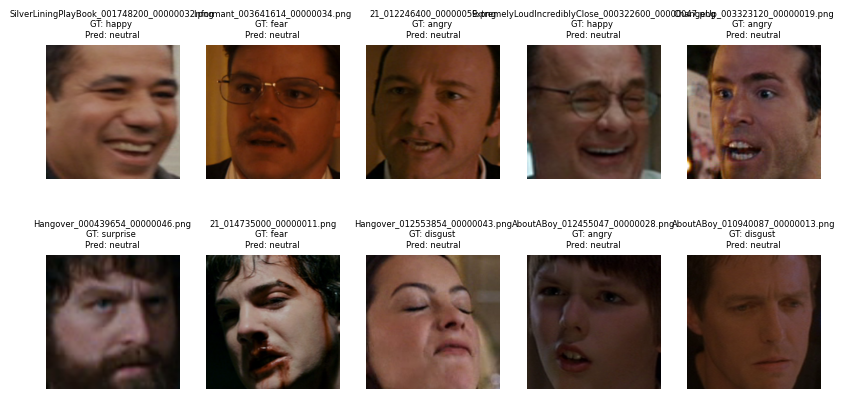

EPOCH: 2  of  150
epoch = 2...in training function


Loss=1.429626703262329 Accuracy=642/913(70.32%) Epoch Avg loss=0.06100448 LR=0.001000: 100%|██████████| 58/58 [00:09<00:00,  6.05it/s]


Test / Val: Average loss: 0.1244, Accuracy: 163/419 (38.90%)

last correct =163 | best correct = 223
EPOCH: 3  of  150
epoch = 3...in training function


Loss=0.36376065015792847 Accuracy=653/913(71.52%) Epoch Avg loss=0.05731293 LR=0.001000: 100%|██████████| 58/58 [00:09<00:00,  6.08it/s]


Test / Val: Average loss: 0.1476, Accuracy: 209/419 (49.88%)

last correct =209 | best correct = 223
EPOCH: 4  of  150
epoch = 4...in training function


Loss=2.1177446842193604 Accuracy=654/913(71.63%) Epoch Avg loss=0.05865831 LR=0.001000: 100%|██████████| 58/58 [00:09<00:00,  6.10it/s]


Test / Val: Average loss: 0.1205, Accuracy: 183/419 (43.68%)

last correct =183 | best correct = 223
EPOCH: 5  of  150
epoch = 5...in training function


Loss=0.018493354320526123 Accuracy=693/913(75.90%) Epoch Avg loss=0.04610059 LR=0.001000: 100%|██████████| 58/58 [00:09<00:00,  6.09it/s]


Test / Val: Average loss: 0.1488, Accuracy: 178/419 (42.48%)

last correct =178 | best correct = 223
EPOCH: 6  of  150
epoch = 6...in training function


Loss=1.1739790439605713 Accuracy=670/913(73.38%) Epoch Avg loss=0.04966146 LR=0.001000: 100%|██████████| 58/58 [00:09<00:00,  6.11it/s]


Test / Val: Average loss: 0.1647, Accuracy: 185/419 (44.15%)

last correct =185 | best correct = 223
EPOCH: 7  of  150
epoch = 7...in training function


Loss=1.0317752361297607 Accuracy=679/913(74.37%) Epoch Avg loss=0.05223460 LR=0.001000: 100%|██████████| 58/58 [00:09<00:00,  6.11it/s]


Test / Val: Average loss: 0.1586, Accuracy: 183/419 (43.68%)

last correct =183 | best correct = 223
EPOCH: 8  of  150
epoch = 8...in training function


Loss=0.5605453252792358 Accuracy=604/913(66.16%) Epoch Avg loss=0.06484765 LR=0.001000: 100%|██████████| 58/58 [00:09<00:00,  6.09it/s]


Test / Val: Average loss: 0.1405, Accuracy: 202/419 (48.21%)

last correct =202 | best correct = 223
EPOCH: 9  of  150
epoch = 9...in training function


Loss=0.3092521131038666 Accuracy=716/913(78.42%) Epoch Avg loss=0.04671581 LR=0.001000: 100%|██████████| 58/58 [00:09<00:00,  6.10it/s]


Test / Val: Average loss: 0.1233, Accuracy: 201/419 (47.97%)

last correct =201 | best correct = 223
EPOCH: 10  of  150
epoch = 10...in training function


Loss=0.05157294496893883 Accuracy=688/913(75.36%) Epoch Avg loss=0.04666645 LR=0.001000: 100%|██████████| 58/58 [00:09<00:00,  6.09it/s]


Test / Val: Average loss: 0.1169, Accuracy: 209/419 (49.88%)

last correct =209 | best correct = 223
EPOCH: 11  of  150
epoch = 11...in training function


Loss=0.10417500138282776 Accuracy=762/913(83.46%) Epoch Avg loss=0.03146743 LR=0.000200: 100%|██████████| 58/58 [00:09<00:00,  6.10it/s]


Test / Val: Average loss: 0.1624, Accuracy: 229/419 (54.65%)

last correct =229 | best correct = 223
Updated the best model with correct: 229



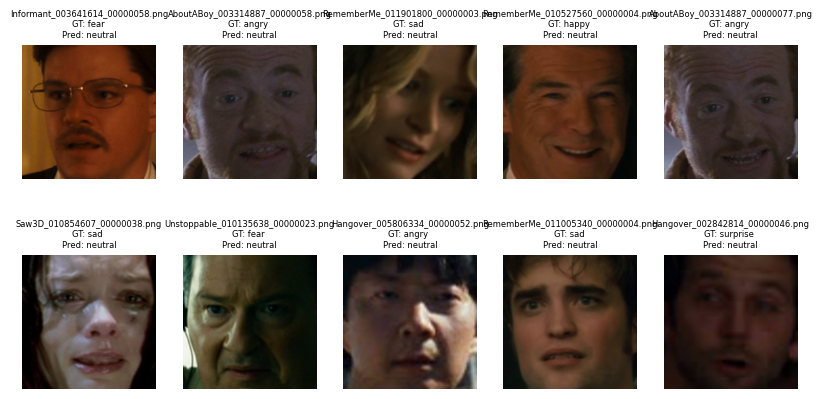

EPOCH: 12  of  150
epoch = 12...in training function


Loss=0.0612432062625885 Accuracy=800/913(87.62%) Epoch Avg loss=0.02241333 LR=0.000200: 100%|██████████| 58/58 [00:09<00:00,  6.10it/s]


Test / Val: Average loss: 0.1674, Accuracy: 223/419 (53.22%)

last correct =223 | best correct = 229
EPOCH: 13  of  150
epoch = 13...in training function


Loss=0.0030741984955966473 Accuracy=806/913(88.28%) Epoch Avg loss=0.02197978 LR=0.000200: 100%|██████████| 58/58 [00:09<00:00,  6.08it/s]


Test / Val: Average loss: 0.1565, Accuracy: 227/419 (54.18%)

last correct =227 | best correct = 229
EPOCH: 14  of  150
epoch = 14...in training function


Loss=0.09493361413478851 Accuracy=817/913(89.49%) Epoch Avg loss=0.02058833 LR=0.000200: 100%|██████████| 58/58 [00:09<00:00,  6.11it/s]


Test / Val: Average loss: 0.1676, Accuracy: 222/419 (52.98%)

last correct =222 | best correct = 229
EPOCH: 15  of  150
epoch = 15...in training function


Loss=0.18826177716255188 Accuracy=830/913(90.91%) Epoch Avg loss=0.01961919 LR=0.000200: 100%|██████████| 58/58 [00:09<00:00,  6.10it/s]


Test / Val: Average loss: 0.1649, Accuracy: 219/419 (52.27%)

last correct =219 | best correct = 229
EPOCH: 16  of  150
epoch = 16...in training function


Loss=0.023588433861732483 Accuracy=826/913(90.47%) Epoch Avg loss=0.01985715 LR=0.000200: 100%|██████████| 58/58 [00:09<00:00,  6.08it/s]


Test / Val: Average loss: 0.1669, Accuracy: 234/419 (55.85%)

last correct =234 | best correct = 229
Updated the best model with correct: 234

EPOCH: 17  of  150
epoch = 17...in training function


Loss=0.0094020776450634 Accuracy=839/913(91.89%) Epoch Avg loss=0.01746193 LR=0.000200: 100%|██████████| 58/58 [00:09<00:00,  6.11it/s]


Test / Val: Average loss: 0.1635, Accuracy: 221/419 (52.74%)

last correct =221 | best correct = 234
EPOCH: 18  of  150
epoch = 18...in training function


Loss=1.2757455806422513e-05 Accuracy=838/913(91.79%) Epoch Avg loss=0.01658781 LR=0.000200: 100%|██████████| 58/58 [00:09<00:00,  6.09it/s]


Test / Val: Average loss: 0.1792, Accuracy: 216/419 (51.55%)

last correct =216 | best correct = 234
EPOCH: 19  of  150
epoch = 19...in training function


Loss=0.0005204344051890075 Accuracy=824/913(90.25%) Epoch Avg loss=0.02017997 LR=0.000200: 100%|██████████| 58/58 [00:09<00:00,  6.10it/s]


Test / Val: Average loss: 0.1736, Accuracy: 233/419 (55.61%)

last correct =233 | best correct = 234
EPOCH: 20  of  150
epoch = 20...in training function


Loss=0.06886468827724457 Accuracy=844/913(92.44%) Epoch Avg loss=0.01606333 LR=0.000040: 100%|██████████| 58/58 [00:09<00:00,  6.10it/s]


Test / Val: Average loss: 0.1640, Accuracy: 239/419 (57.04%)

last correct =239 | best correct = 234
Updated the best model with correct: 239

EPOCH: 21  of  150
epoch = 21...in training function


Loss=0.22309564054012299 Accuracy=850/913(93.10%) Epoch Avg loss=0.01525568 LR=0.000040: 100%|██████████| 58/58 [00:09<00:00,  6.11it/s]


Test / Val: Average loss: 0.1680, Accuracy: 242/419 (57.76%)

last correct =242 | best correct = 239
Updated the best model with correct: 242



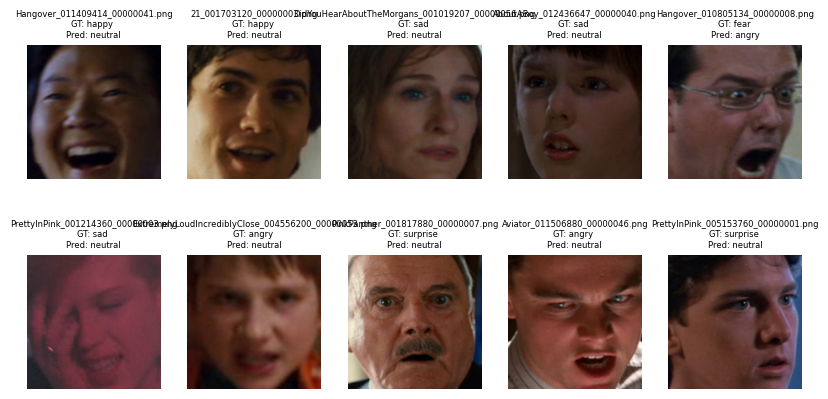

EPOCH: 22  of  150
epoch = 22...in training function


Loss=2.3692507966188714e-05 Accuracy=852/913(93.32%) Epoch Avg loss=0.01464959 LR=0.000040: 100%|██████████| 58/58 [00:09<00:00,  6.08it/s]


Test / Val: Average loss: 0.1710, Accuracy: 238/419 (56.80%)

last correct =238 | best correct = 242
EPOCH: 23  of  150
epoch = 23...in training function


Loss=0.020209509879350662 Accuracy=858/913(93.98%) Epoch Avg loss=0.01275409 LR=0.000040: 100%|██████████| 58/58 [00:09<00:00,  6.08it/s]


Test / Val: Average loss: 0.1773, Accuracy: 246/419 (58.71%)

last correct =246 | best correct = 242
Updated the best model with correct: 246

EPOCH: 24  of  150
epoch = 24...in training function


Loss=0.14898568391799927 Accuracy=845/913(92.55%) Epoch Avg loss=0.01349098 LR=0.000040: 100%|██████████| 58/58 [00:09<00:00,  6.08it/s]


Test / Val: Average loss: 0.1797, Accuracy: 239/419 (57.04%)

last correct =239 | best correct = 246
EPOCH: 25  of  150
epoch = 25...in training function


Loss=0.010854464024305344 Accuracy=850/913(93.10%) Epoch Avg loss=0.01414221 LR=0.000040: 100%|██████████| 58/58 [00:09<00:00,  6.07it/s]


Test / Val: Average loss: 0.1784, Accuracy: 239/419 (57.04%)

last correct =239 | best correct = 246
EPOCH: 26  of  150
epoch = 26...in training function


Loss=0.2882944345474243 Accuracy=865/913(94.74%) Epoch Avg loss=0.01217432 LR=0.000040: 100%|██████████| 58/58 [00:09<00:00,  6.07it/s]


Test / Val: Average loss: 0.1792, Accuracy: 240/419 (57.28%)

last correct =240 | best correct = 246
EPOCH: 27  of  150
epoch = 27...in training function


Loss=2.2674571482639294e-06 Accuracy=867/913(94.96%) Epoch Avg loss=0.01061020 LR=0.000040: 100%|██████████| 58/58 [00:09<00:00,  6.07it/s]


Test / Val: Average loss: 0.1830, Accuracy: 238/419 (56.80%)

last correct =238 | best correct = 246
EPOCH: 28  of  150
epoch = 28...in training function


Loss=-0.0 Accuracy=861/913(94.30%) Epoch Avg loss=0.01092047 LR=0.000040: 100%|██████████| 58/58 [00:09<00:00,  6.07it/s]


Test / Val: Average loss: 0.1995, Accuracy: 242/419 (57.76%)

last correct =242 | best correct = 246
EPOCH: 29  of  150
epoch = 29...in training function


Loss=0.008832136169075966 Accuracy=859/913(94.09%) Epoch Avg loss=0.01183461 LR=0.000008: 100%|██████████| 58/58 [00:09<00:00,  6.09it/s]


Test / Val: Average loss: 0.1880, Accuracy: 241/419 (57.52%)

last correct =241 | best correct = 246
EPOCH: 30  of  150
epoch = 30...in training function


Loss=0.2357550412416458 Accuracy=866/913(94.85%) Epoch Avg loss=0.01088237 LR=0.000008: 100%|██████████| 58/58 [00:09<00:00,  6.10it/s]


Test / Val: Average loss: 0.1916, Accuracy: 243/419 (58.00%)

last correct =243 | best correct = 246
EPOCH: 31  of  150
epoch = 31...in training function


Loss=0.02265898697078228 Accuracy=857/913(93.87%) Epoch Avg loss=0.01474464 LR=0.000008: 100%|██████████| 58/58 [00:09<00:00,  6.07it/s]


Test / Val: Average loss: 0.1995, Accuracy: 241/419 (57.52%)

last correct =241 | best correct = 246


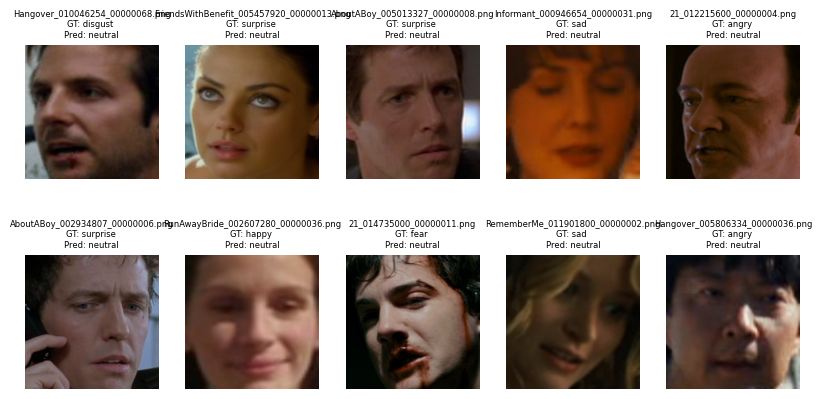

EPOCH: 32  of  150
epoch = 32...in training function


Loss=0.014169626869261265 Accuracy=869/913(95.18%) Epoch Avg loss=0.01143237 LR=0.000008: 100%|██████████| 58/58 [00:09<00:00,  6.05it/s]


Test / Val: Average loss: 0.1858, Accuracy: 241/419 (57.52%)

last correct =241 | best correct = 246
EPOCH: 33  of  150
epoch = 33...in training function


Loss=0.005604006350040436 Accuracy=867/913(94.96%) Epoch Avg loss=0.01121572 LR=0.000008: 100%|██████████| 58/58 [00:09<00:00,  6.09it/s]


Test / Val: Average loss: 0.1993, Accuracy: 242/419 (57.76%)

last correct =242 | best correct = 246
EPOCH: 34  of  150
epoch = 34...in training function


Loss=4.189305400359444e-05 Accuracy=862/913(94.41%) Epoch Avg loss=0.01176574 LR=0.000008: 100%|██████████| 58/58 [00:09<00:00,  6.07it/s]


Test / Val: Average loss: 0.1947, Accuracy: 240/419 (57.28%)

last correct =240 | best correct = 246
-------Early Stopping at epoch 34---
Best model loaded
Validation results with sfew
Test / Val: Average loss: 0.1901, Accuracy: 246/419 (58.71%)



In [ ]:
# Training block
print('------ Training started for Non DANN Model ---- ')
print(f'starting LR : {lr}')
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1, " of ", EPOCHS)

    #Train Model
    avg_epoch_loss, curr_lr = train_model_local_lr (model = model,
                                          device = device,
                                          data_loader = data_loader['source']['train'],
                                          optimizer = optimizer,
                                          epoch = epoch,
                                          class_loss_function = criterion_class)
    train_losses.append(avg_epoch_loss)
    lr_schedule.append(curr_lr)

    #Validate Model
    correct, avg_epoch_val_loss = test_model_local(model= model,
                                    device= device,
                                    data_loader = data_loader['source']['val'],
                                    class_loss_function = criterion_class
                                    )

    val_losses.append(avg_epoch_val_loss)
    list_val_correct.append(correct)

    #Adding Scheduler #TODO: ADD SCHEDULER
    scheduler.step(correct) #applying scheduler on accuracy proxy, i.e. correct

    # # Check if the current model has the best validation loss
    # print(f'Last Epoch Val Loss = {avg_epoch_val_loss} | Best Val Loss = {best_val_loss}' )
    # if avg_epoch_val_loss < best_val_loss:
    #   best_val_loss = avg_epoch_val_loss
    #   # save the current model state as the best model state
    #   best_model_state = deepcopy(non_dann_model.state_dict())
    #   print(f'Updated the best model with validation loss: {best_val_loss}\n')

    # check if the current model has the best accuracy
    print (f'last correct ={correct} | best correct = {best_val_acc}')
    if correct > best_val_acc:
      best_val_acc = correct
      # save the current model state as the best model state
      best_model_state = deepcopy(model.state_dict())
      print(f'Updated the best model with correct: {correct}\n')

    list_best_val_correct.append(best_val_acc)

    # early stopping
    # if early_stopping_difference(val_losses,
    #                              patience = early_stop_patience,
    #                              difference= early_stop_difference):
    #   print (f'-------Early Stopping at epoch {epoch+1}---')
    #   epoch_converge = epoch+1
    #   break

    if early_stopping_difference(list_val_correct,
                                 patience = early_stop_patience,
                                 difference= early_stop_difference):
      print (f'-------Early Stopping at epoch {epoch+1}---')
      epoch_converge = epoch+1
      break

    if early_stopping_difference(list_best_val_correct,
                                 patience = 2*early_stop_patience,
                                 difference= 0):
      print (f'-------Early Stopping at epoch {epoch+1}---')
      epoch_converge = epoch+1
      break



    ## showing misclassification images after every 10 epochs
    if epoch % 10 == 0:
      list_misclassified_images = get_misclassified_images_list(model= model,
                                                                device = device,
                                                                test_loader = data_loader['source']['val'],
                                                                num_image = 10)
      plot_misclassified_images(list_misclassified_images)

## using params of best model to update model
if best_model_state: # only update if best model has been saved, else the last one would be picked up
  # best_non_dann_model.load_state_dict(best_model_state)
  best_model.load_state_dict(best_model_state)
  print('Best model loaded')


print(f'Validation results with {source_name}')

correct, test_loss_source = test_model_local(model= best_model, #best_non_dann_model, #non_dann_model,
                                    device= device,
                                    data_loader = data_loader['source']['val'], # source val loader
                                    class_loss_function = criterion_class)


dict_non_dann_losses = {'train_losses' : train_losses,
                                       'val_losses': val_losses,
                                       'test_loss_source' : test_loss_source,
                                      #  'test_loss_target' : test_loss_target,
                                       'epoch_convergence' : epoch_converge,
                                       'lr': lr_schedule}


### Validation on Test Dataset - only when data loader is avaialable



In [ ]:
# test_model_local(model= best_model,
#                             device= device,
#                             data_loader = data_loader['target']['val'], # target val loader
#                             class_loss_function = runconfig.criterion_class)

### `Model Performance Metrics`

In [27]:
true_labels, predicted_labels, accuracy, precision, conf_matrix, class_report = performance_metric(model= best_model,
                                                                                                   device= device,
                                                                                                   data_loader = data_loader['source']['val'], # source val loader
                                                                                                   )

Accuracy: 0.5871121718377088
Precision: 0.5730582311207125
Confusion Matrix:
[[46  9  2  6  5  6  1]
 [ 2  5  1  4  1  6  3]
 [ 6  2 10  3  7  7  8]
 [ 4  0  0 64  0  0  4]
 [ 9  1  2  3 27  5  5]
 [ 2  2  4  2  3 62  9]
 [ 4  2  3  5 15 10 32]]
          Angry  Disgust  Fear  Happy  Sad  Surprise  Neutral
Angry        46        9     2      6    5         6        1
Disgust       2        5     1      4    1         6        3
Fear          6        2    10      3    7         7        8
Happy         4        0     0     64    0         0        4
Sad           9        1     2      3   27         5        5
Surprise      2        2     4      2    3        62        9
Neutral       4        2     3      5   15        10       32
Classification Report:
              precision    recall  f1-score   support

       Angry       0.63      0.61      0.62        75
     Disgust       0.24      0.23      0.23        22
        Fear       0.45      0.23      0.31        43
       Happy      

### Saving Non-Dann Model

In [28]:
target_name = 'expw'
MODEL_DIR = dataconfig.MODEL_DIR
NON_DANN_SFEW_DIR = dataconfig.NON_DANN_SFEW_DIR
SPECIFIC_MODEL_DIR = Path(os.path.join(MODEL_DIR, f'non_dann_{source_name}_{target_name}'))
print(MODEL_DIR, NON_DANN_SFEW_DIR, SPECIFIC_MODEL_DIR)

/content/gdrive/MyDrive/CV_FER/models /content/gdrive/MyDrive/CV_FER/models/non_dann_sfew /content/gdrive/MyDrive/CV_FER/models/non_dann_sfew_expw


In [29]:
model_name = f'non_dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}_wo_se_a.pt' #"non_dann_sfew_" +str(time.strftime("%d_%m"))+ ".pt"
print("\nDO VERIFY THE MODEL NAME BEFORE MOVING AHEAD: ", model_name)


DO VERIFY THE MODEL NAME BEFORE MOVING AHEAD:  non_dann_sfew_expw_23_05_wo_se_a.pt


In [30]:
# model_name = f'non_dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}_{se}.pt' #"non_dann_sfew_" +str(time.strftime("%d_%m"))+ ".pt"
# dataconfig = DataConfig()
# NON_DANN_SFEW_DIR = dataconfig.NON_DANN_SFEW_DIR
if not SPECIFIC_MODEL_DIR.exists():
    # Create the directory
    SPECIFIC_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {SPECIFIC_MODEL_DIR} created successfully.')
else:
    print(f'Directory {SPECIFIC_MODEL_DIR} already exists.')

torch.save(best_model.state_dict(), Path(SPECIFIC_MODEL_DIR,model_name))

Directory /content/gdrive/MyDrive/CV_FER/models/non_dann_sfew_expw already exists.


In [31]:
model_name

'non_dann_sfew_expw_23_05_wo_se_a.pt'

## Dataset - Target

- EXPW dataset

In [32]:
# checking the mounted drive and mounting if not done
import os
if not os.path.exists('/content/gdrive'):
  from google.colab import drive
  drive.mount('/content/gdrive')
else:
    print("Google Drive is already mounted.")


Google Drive is already mounted.


### Creating Dataloader for EXPW

In [33]:
# from da_cv_fer.ds_expw_crop_race import EXPWCROPRACE
from da_cv_fer.ds_expw_crop_image_race import EXPWIMAGECROPRACE


expw_obj = EXPWIMAGECROPRACE(type = None, crop_at_runtime=False)

expw_train_ds, expw_val_ds = expw_obj.get_dataset()
expw_train_loader, expw_val_loader = expw_obj.get_dataloader()
print(f' length of EXPW dataset : {len(expw_train_loader.dataset)} , {len(expw_train_ds)}')

desitination file path = dataset/expwds/expwds.zip
Directory dataset/expwds created successfully.
Dataset URL: https://www.kaggle.com/datasets/mohammedaaltaha/expwds


100%|██████████| 7.68G/7.68G [07:51<00:00, 17.5MB/s]



File downloaded successfully from https://www.kaggle.com/datasets/mohammedaaltaha/expwds to dataset/expwds/expwds.zip
Unzipped Files already exist in dataset/expwds, not extracted
---NOT CROPPING AT RUNTIME --
 before splitting : image_label_dict 68096
*** Starting creation of dataset based on RACE data ***
pickle_raceds_crop_list_path:  /content/gdrive/MyDrive/CV_FER/dataset/expw_raceds_crop_image_dict.pkl
train list [('crying_european_355.jpg', 6), ('crying_son_40.jpg', 4)] <class 'list'> 1000
size of dataset (list_img_label): 1000
*** Completed creation of dataset based on RACE data ***
---NOT CROPPING AT RUNTIME--, flag_create_crop_contents value: False
Directory created: dataset/expwds/cropped
**** dataset/expwds/cropped is empty***

 
18 were not able to crop
982 cropped images created in cropped
---NOT CROPPING AT RUNTIME --
*** Starting creation of dataset based on RACE data ***
pickle_raceds_crop_list_path:  /content/gdrive/MyDrive/CV_FER/dataset/expw_raceds_crop_image_dict.p

In [ ]:
# {0:"Angry",
#             1:"Disgust",
#             2:"Fear",
#             3:"Happy",
#             4:"Sad",
#             5:"Surprise",
#             6:"Neutral"}

# ["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"]

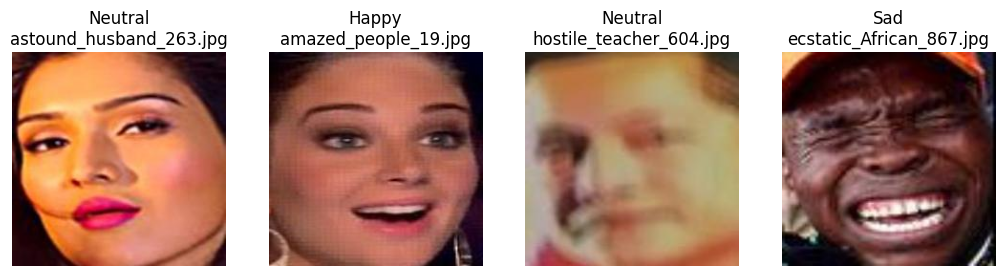

In [34]:
show_batch(expw_train_loader,["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"],4, normalized = False)

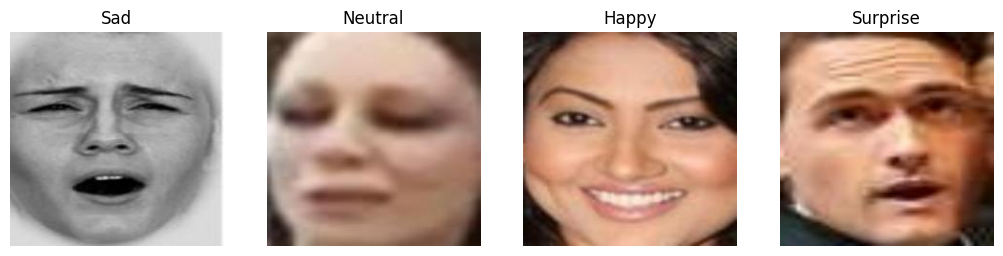

In [35]:
show_batch(expw_val_loader,["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"],4, normalized = False)

In [36]:
if expw_train_loader is None:
  sfew_loader = {'name': 'sfew',
               'train':sfew_train_loader,
               'val':sfew_val_loader
               }
  data_loader = {'source' : sfew_loader}
  source_name = data_loader['source']['name']
  target_name = "expw"
else:
  sfew_loader = {'name': 'sfew',
                'train':sfew_train_loader,
                'val':sfew_val_loader
                }

  expw_loader = {'name': 'expw',
                'train':expw_train_loader,
                'val':expw_val_loader
                }

  data_loader = {'source' : sfew_loader,
                'target' : expw_loader}

  source_name = data_loader['source']['name']
  target_name = data_loader['target']['name']

### Validation of non dann on Test Dataset - only when data loader is avaialable


In [116]:
test_model_local(model= best_model.to(device),
                            device= device,
                            data_loader = data_loader['target']['val'], # target val loader
                            class_loss_function = nn.CrossEntropyLoss(weight = class_weights).to(device=device))

Test / Val: Average loss: 0.3321, Accuracy: 2679/8458 (31.67%)



(2679, 0.3320725904229291)

In [117]:
torch.cuda.empty_cache()

## Loading NON DANN Model for DANN and DANN EWC


In [44]:
# source_name = "sfew"
# target_name = "expw"
today_model_name = f'non_dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}_wo_se_a.pt' # Typical - non_dann_sfew_expw_30_01.pt This may change, use specific model name if required4
print(f'today_model_name {today_model_name}')
# custom_model_name= 'non_dann_sfew_expw_08_04.pt'
# print(f'custom_model_name {custom_model_name}')

model_name = today_model_name

print("\n****model name that would be used for loading: ", model_name)

today_model_name non_dann_sfew_expw_23_05_wo_se_a.pt

****model name that would be used for loading:  non_dann_sfew_expw_23_05_wo_se_a.pt


### Loading Structure of Models

In [45]:
if not device:
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  print(device)

In [46]:
# from data_config import DataConfig
dataconfig_1 = DataConfig()
MODEL_DIR = dataconfig_1.MODEL_DIR

MODEL_PATH = Path(os.path.join(MODEL_DIR, f'non_dann_{source_name}_{target_name}', model_name))

In [47]:
model_dann =  DANN_VGG(model_pretrained = model_pretrained, num_classes=7)  # skeleton copy

model_dann.load_state_dict(torch.load(MODEL_PATH,map_location=torch.device(device)))

<All keys matched successfully>

In [48]:
model_dann_ewc = deepcopy(model_dann) # saves training time - check with all

In [ ]:
# model_dann_ewc_2 =  DANN_VGG(model_pretrained = model_pretrained, num_classes=7)  # skeleton copy

# model_dann_ewc_2.load_state_dict(torch.load(MODEL_PATH,map_location=torch.device(device)))


<All keys matched successfully>

In [49]:
model_dann

DANN_VGG(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256,

In [50]:
params = {name: param for name, param in model_dann.named_parameters() if param.requires_grad}
params.keys()

dict_keys(['feature_extractor.0.weight', 'feature_extractor.0.bias', 'feature_extractor.2.weight', 'feature_extractor.2.bias', 'feature_extractor.5.weight', 'feature_extractor.5.bias', 'feature_extractor.7.weight', 'feature_extractor.7.bias', 'feature_extractor.10.weight', 'feature_extractor.10.bias', 'feature_extractor.12.weight', 'feature_extractor.12.bias', 'feature_extractor.14.weight', 'feature_extractor.14.bias', 'feature_extractor.17.weight', 'feature_extractor.17.bias', 'feature_extractor.19.weight', 'feature_extractor.19.bias', 'feature_extractor.21.weight', 'feature_extractor.21.bias', 'feature_extractor.24.weight', 'feature_extractor.24.bias', 'feature_extractor.26.weight', 'feature_extractor.26.bias', 'feature_extractor.28.weight', 'feature_extractor.28.bias', 'feature_extractor.31.weight', 'feature_extractor.31.bias', 'class_classifier.1.weight', 'class_classifier.1.bias', 'class_classifier.4.weight', 'class_classifier.4.bias', 'domain_classifier.1.weight', 'domain_classif

## Test Function

In [51]:
def get_correct_preds(prediction, labels):
    """
    Function to return total number of correct predictions
    :param prediction: Model predictions on a given sample of data
    :param labels: Correct labels of a given sample of data
    :return: Number of correct predictions
    """
    return prediction.argmax(dim=1).eq(labels.argmax(dim=1)).sum().item()

def test_model_local(model, device, data_loader, mode= 'test',
               class_loss_function = nn.CrossEntropyLoss() ):
    model = model.to(device)
    model.eval() # evaluation mode

    # variables to track loss and accuracy
    test_loss = 0.0
    correct = 0

    # Disable gradient updation
    with torch.no_grad():
        # Iterate over each batch and fetch images and labels from the batch
        for batch_idx, batch in enumerate(data_loader):
            images, labels = batch[0].to(device), batch[1].to(device)

            class_output,_,_  = model((images*255)) # forward pass, output = {class}
            class_loss = class_loss_function(class_output,labels) # Calculate Loss

            test_loss += class_loss.item() # sum up batch loss

            # Sum up batch correct predictions
            correct += get_correct_preds(class_output, labels)

    # Calculate test loss for a epoch
    test_loss /= len(data_loader.dataset)

    print('Test / Val: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))


    return correct, test_loss

## DANN Execution: Training, Validating, Saving

### DANN Execution Function

In [52]:
def execute_dann(model,
                 device,
                 source_train_loader, source_val_loader,
                 target_train_loader, target_val_loader,
                 optimizer,
                 n_epochs, # total number of epochs (different from individual epoch)
                 class_loss_function = nn.CrossEntropyLoss(),
                 domain_loss_function = nn.BCEWithLogitsLoss(),
                 scheduler = None,
                 early_stop_patience = None,
                 early_stop_difference = None
                 ):

    train_losses = [] # to capture train losses over training epochs
    val_losses = [] # to capture validation loss over epochs
    list_lr =[] # to capture lr over epochs
    list_val_correct = [] # to capture validation accuracy over epochs
    list_best_val_correct = [] # to capture best validtion accuracy over epochs


    epoch_converge = 0
    max_batches = min(len(source_train_loader), len(target_train_loader)) # Trying to check which is having less batches.
    model = model.to(device)

    # model.apply(weights_init) # TODO: skipping weights update - we can experimentation later on, and see if this helps
    list_alpha =[]


    # for best model
    best_model = deepcopy(model).to(device) # for best model
    best_val_loss = float('inf') # Initialize variables to track the best validation loss
    best_val_acc = 0 # Initialize variable to track best accuracy
    best_model_state = None # Initialize variables to track the best model state


    for epoch_idx in range(n_epochs):
        print(f'epoch = {epoch_idx+1}...in DANN execution function')
        source_iterator = iter(source_train_loader)
        target_iterator = iter (target_train_loader)
        epoch_task_loss = 0
        epoch_domain_loss =  0
        epoch_total_loss = 0
        processed = 0

        for batch_idx in range(max_batches-1):
            # p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
            # alpha = 2. / (1. + np.exp(-10 * p)) - 1
            alpha = 1.0
            list_alpha.append(alpha)
            alpha = torch.tensor(alpha)

            model.train() # everytime ?
            optimizer.zero_grad() # flushing out the accumulated gradients

            #---------------------Source Dataset Training ------------------------#
            source_batch = next(source_iterator)
            source_batch[0] = source_batch[0] * 255.0  # Convert inputs from [0, 1] to [0, 255]

            source_images, source_labels = source_batch[0].to(device), source_batch[1].to(device) # getting images and labels, on device
            source_class_outputs, source_domain_outputs, _ = model(source_images, alpha=alpha) # forward pass, output = {class, domain, feature}


            loss_source_class = class_loss_function(source_class_outputs, source_labels) # calculating class loss

            source_domain_inputs = torch.tensor([1., 0.]*len(source_batch[0])).view(-1,2).to(device) # Source Image == [1., 0.]

            loss_source_domain = domain_loss_function(source_domain_outputs, source_domain_inputs) # calculating domain loss

            processed += len(source_batch[0])

            #---------------------Target Dataset Training ------------------------#
            target_batch = next (target_iterator)
            target_batch[0] = target_batch[0] * 255.0  # Convert inputs from [0, 1] to [0, 255]
            target_images = target_batch[0].to(device) # getting images, on device. There are no labels for target
            _, target_domain_outputs, _ = model(target_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            target_domain_inputs = torch.tensor([0., 1.]*len(source_batch[0])).view(-1,2).to(device)  # Target Image == [0., 1.]
            # print(f' target domain input shape {target_domain_inputs.shape}, output shape {target_domain_outputs.shape}')

            loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)  # calculating domain loss


            #---------------------Combining Loss ------------------------#
            total_loss = loss_source_class + (loss_source_domain + loss_target_domain) # changed the loss
            total_loss.backward() #backpropogation, creating gradients
            optimizer.step() # updating the params

            epoch_task_loss += loss_source_class.item()
            epoch_domain_loss += loss_source_domain.item() + loss_target_domain.item()
            epoch_total_loss += total_loss.item()

            curr_lr = optimizer.param_groups[0]['lr'] # current learning rate
            list_lr.append(curr_lr)

            # after 10 batches
            if (batch_idx % 10 == 0):
                print("Epoch[{}/{}] Step[{}/{}]: loss_total={:.4f} / domain_loss_target={:.4f} / domain_loss_source={:.4f} / task_loss={:.4f} / domain_loss={:.4f} / alpha={:.2f} / lr={:.6f}"
              .format(epoch_idx + 1,
                      n_epochs,
                      batch_idx + 1,
                      max_batches,
                      total_loss.item(),
                      loss_target_domain.item()
                      ,loss_source_domain.item()
                      ,loss_source_class.item()
                      ,loss_source_domain.item()+loss_source_class.item(),
                      alpha,
                      curr_lr
                      ))
        # After every epoch
        avg_train_task_loss =  float("{:.6f}".format(epoch_task_loss/processed))
        train_losses.append(avg_train_task_loss)

        # #Scheduler
        # if scheduler:
        #   scheduler.step(avg_train_task_loss) ## applying scheduler on training loss

        #Validate Model after every epoch
        correct, avg_val_task_loss = test_model_local(model= model,
                                                device= device,
                                                data_loader = source_val_loader,
                                                class_loss_function = class_loss_function)
        val_losses.append(avg_val_task_loss)

        # # Check if the current model has the best validation loss
        # print(f'Last Epoch Val Loss = {avg_val_task_loss} | Best Val Loss = {best_val_loss}' )
        # if avg_val_task_loss < best_val_loss:
        #   best_val_loss = avg_val_task_loss
        #   # save the current model state as the best model state
        #   best_model_state = deepcopy(model.state_dict())
        #   print(f'Updated the best model with validation loss: {best_val_loss}\n')

        list_val_correct.append(correct)

        #Adding Scheduler #TODO: ADD SCHEDULER
        if scheduler:
          scheduler.step(correct) #applying scheduler on accuracy proxy, i.e. correct


        # check if the current model has the best accuracy
        print (f'last correct ={correct} | best correct = {best_val_acc}')
        if correct > best_val_acc:
          best_val_acc = correct
          # save the current model state as the best model state
          best_model_state = deepcopy(model.state_dict())
          print(f'Updated the best model with correct: {correct}\n')

        list_best_val_correct.append(best_val_acc) # appending the best one for early stopping



        #TODO: Early Stopping
        if early_stop_patience and early_stop_difference: # early stopping required
          if early_stopping_difference(list_val_correct,
                                       patience = early_stop_patience,
                                       difference= early_stop_difference):
            print (f'-------Early Stopping at epoch {epoch_idx+1}---')
            epoch_converge = epoch_idx+1
            break # break from epoch loop

        if early_stop_patience and early_stop_difference: # early stopping based on best accuracy
          if early_stopping_difference(val_losses,
                                       patience = 2*early_stop_patience,
                                       difference= 0):
            print (f'-------Early Stopping at epoch {epoch_idx+1}---')
            epoch_converge = epoch_idx+1
            break # break from epoch loop

            ## showing misclassification images after every 10 epochs
        if epoch_idx % 10 == 0:
          list_misclassified_images = get_misclassified_images_list(model= model,
                                                                    device = device,
                                                                    test_loader = source_val_loader,
                                                                    num_image = 10)
          plot_misclassified_images(list_misclassified_images)


    # Testing when the training is over - completed or early stopped
    ## using params of best model to update model
    if best_model_state: # only update if best model has been saved, else the last one would be picked up
      model.load_state_dict(best_model_state)
      print('Best model loaded')

    correct, test_loss_source = test_model_local(model= model,
                            device= device,
                            data_loader = source_val_loader, # source val loader
                            class_loss_function = class_loss_function)

    correct, test_loss_target = test_model_local(model= model,
                            device= device,
                            data_loader = target_val_loader, # target val loader
                            class_loss_function = class_loss_function)

    dict_dann_losses = {'train_losses' : train_losses,
                        'val_losses': val_losses,
                        'test_loss_source' : test_loss_source,
                        'test_loss_target' : test_loss_target,
                        'epoch_convergence' : epoch_converge,
                        'list_alpha' : list_alpha,
                        'lr':list_lr}

    print(f'alpha list \n {list_alpha}')
    return model, dict_dann_losses


### DANN Execution Config

In [53]:
runconfig = RunConfig()
lr_dann = runconfig.inital_lr
lr_dann = lr_dann
lr_dann = 0.001 # override
optimizer_dann = optim.SGD(model_dann.parameters(), lr = lr_dann, momentum = 0.9)
# n_epochs = runconfig.EPOCHS if int(dict_non_dann_losses['epoch_convergence']) == 0 else int(dict_non_dann_losses['epoch_convergence'])

# n_epochs =  3 # override
n_epochs = runconfig.EPOCHS

print("EPOCHS", n_epochs)


# # ReduceLRonPlateau Scheduler Params
# scheduler_patience = runconfig.scheduler_patience
# scheduler_factor = runconfig.scheduler_factor
# scheduler_threshold = runconfig.scheduler_threshold
# Early stopping params
# early_stop_patience = runconfig.early_stop_patience
# early_stop_difference = runconfig.early_stop_difference

# ReduceLRonPlateau Scheduler Params
scheduler_patience = 8 #runconfig.scheduler_patience
scheduler_factor = runconfig.scheduler_factor
scheduler_threshold = 25 #runconfig.scheduler_threshold

# Early stopping params
early_stop_patience = 10 #runconfig.early_stop_patience
early_stop_difference = 15 #runconfig.early_stop_difference


# Set up the ReduceLROnPlateau scheduler
# scheduler = ReduceLROnPlateau(optimizer_dann,
#                               mode='min',
#                               factor=scheduler_factor,
#                               patience=scheduler_patience,
#                               threshold = scheduler_threshold,
#                               min_lr=1e-6,
#                               verbose= True)

# Set up the ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer_dann,
                              # mode='min',
                              mode='max',
                              factor=scheduler_factor,
                              patience=scheduler_patience,
                              threshold = scheduler_threshold,
                              threshold_mode='abs',
                              min_lr=1e-6,
                              verbose= True)



EPOCHS 150


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


### DANN Execution

------------training started for DANN Model ------------------
epoch = 1...in DANN execution function
Epoch[1/150] Step[1/58]: loss_total=1.5754 / domain_loss_target=0.6616 / domain_loss_source=0.7194 / task_loss=0.1944 / domain_loss=0.9138 / alpha=1.00 / lr=0.001000
Epoch[1/150] Step[11/58]: loss_total=1.5150 / domain_loss_target=0.5262 / domain_loss_source=0.7673 / task_loss=0.2216 / domain_loss=0.9888 / alpha=1.00 / lr=0.001000
Epoch[1/150] Step[21/58]: loss_total=2.1602 / domain_loss_target=0.7062 / domain_loss_source=0.6549 / task_loss=0.7990 / domain_loss=1.4539 / alpha=1.00 / lr=0.001000
Epoch[1/150] Step[31/58]: loss_total=1.8534 / domain_loss_target=0.4548 / domain_loss_source=1.0465 / task_loss=0.3521 / domain_loss=1.3985 / alpha=1.00 / lr=0.001000
Epoch[1/150] Step[41/58]: loss_total=2.2435 / domain_loss_target=0.7135 / domain_loss_source=0.6212 / task_loss=0.9088 / domain_loss=1.5300 / alpha=1.00 / lr=0.001000
Epoch[1/150] Step[51/58]: loss_total=1.5662 / domain_loss_target

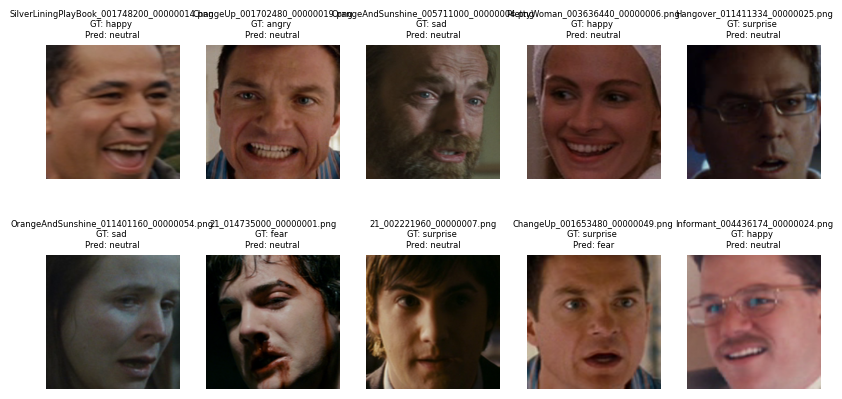

epoch = 2...in DANN execution function
Epoch[2/150] Step[1/58]: loss_total=2.3755 / domain_loss_target=0.6463 / domain_loss_source=0.7720 / task_loss=0.9572 / domain_loss=1.7293 / alpha=1.00 / lr=0.001000
Epoch[2/150] Step[11/58]: loss_total=2.5986 / domain_loss_target=0.5690 / domain_loss_source=0.7204 / task_loss=1.3092 / domain_loss=2.0296 / alpha=1.00 / lr=0.001000
Epoch[2/150] Step[21/58]: loss_total=2.1612 / domain_loss_target=0.8011 / domain_loss_source=0.6776 / task_loss=0.6825 / domain_loss=1.3601 / alpha=1.00 / lr=0.001000
Epoch[2/150] Step[31/58]: loss_total=2.0950 / domain_loss_target=0.7126 / domain_loss_source=0.6882 / task_loss=0.6942 / domain_loss=1.3824 / alpha=1.00 / lr=0.001000
Epoch[2/150] Step[41/58]: loss_total=1.6790 / domain_loss_target=0.5433 / domain_loss_source=0.8632 / task_loss=0.2725 / domain_loss=1.1358 / alpha=1.00 / lr=0.001000
Epoch[2/150] Step[51/58]: loss_total=1.6661 / domain_loss_target=0.5187 / domain_loss_source=0.8147 / task_loss=0.3327 / domain

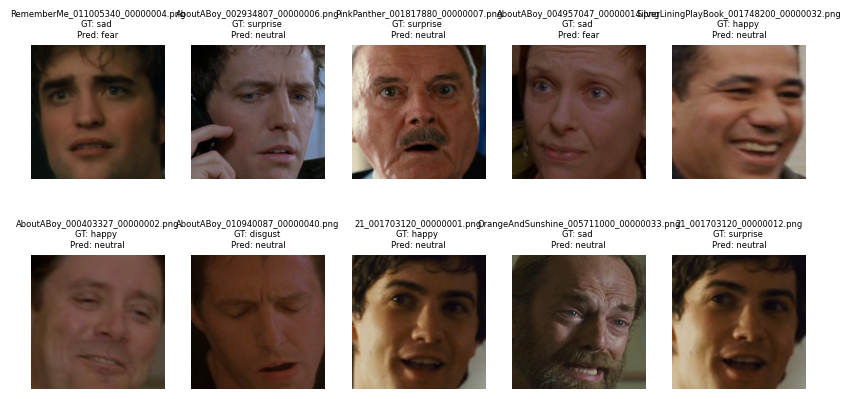

epoch = 12...in DANN execution function
Epoch[12/150] Step[1/58]: loss_total=1.4798 / domain_loss_target=0.7250 / domain_loss_source=0.5739 / task_loss=0.1809 / domain_loss=0.7548 / alpha=1.00 / lr=0.000200
Epoch[12/150] Step[11/58]: loss_total=1.5007 / domain_loss_target=0.6836 / domain_loss_source=0.6548 / task_loss=0.1623 / domain_loss=0.8171 / alpha=1.00 / lr=0.000200
Epoch[12/150] Step[21/58]: loss_total=1.8174 / domain_loss_target=0.8454 / domain_loss_source=0.6876 / task_loss=0.2844 / domain_loss=0.9720 / alpha=1.00 / lr=0.000200
Epoch[12/150] Step[31/58]: loss_total=1.6112 / domain_loss_target=0.6797 / domain_loss_source=0.6567 / task_loss=0.2747 / domain_loss=0.9314 / alpha=1.00 / lr=0.000200
Epoch[12/150] Step[41/58]: loss_total=1.7836 / domain_loss_target=0.7320 / domain_loss_source=0.6506 / task_loss=0.4010 / domain_loss=1.0515 / alpha=1.00 / lr=0.000200
Epoch[12/150] Step[51/58]: loss_total=1.4901 / domain_loss_target=0.6408 / domain_loss_source=0.6511 / task_loss=0.1983 /

In [54]:
print(f'------------training started for DANN Model ------------------')

dann_model_trained, dict_dann_losses = execute_dann(model=model_dann,
                                                    device=device,
                                                    source_train_loader = data_loader['source']['train'], #sfew_train_loader,
                                                    source_val_loader = data_loader['source']['val'], #sfew_val_loader,
                                                    target_train_loader = data_loader['target']['train'], #expw_train_loader,
                                                    target_val_loader = data_loader['target']['val'], #expw_val_loader,
                                                    optimizer = optimizer_dann,
                                                    n_epochs = n_epochs,
                                                    class_loss_function = nn.CrossEntropyLoss(weight = class_weights).to(device=device),
                                                    # class_loss_function = runconfig.criterion_class,
                                                    domain_loss_function = runconfig.criterion_domain,
                                                    scheduler = scheduler,
                                                    early_stop_patience = early_stop_patience,
                                                    early_stop_difference = early_stop_difference
                                                    )

### DANN Saving

In [55]:
dann_model_name = f'dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}_wo_se_a.pt' # "dann_sfew_expw_" + str(time.strftime("%d_%m")) + ".pt"
print(dann_model_name)

# from data_config import DataConfig
dataconfig_1 = DataConfig()
MODEL_DIR = dataconfig_1.MODEL_DIR

DANN_MODEL_DIR =  Path(os.path.join(MODEL_DIR, f'dann_{source_name}_{target_name}'))


if not DANN_MODEL_DIR.exists():
    # Create the directory
    DANN_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {DANN_MODEL_DIR} created successfully.')
else:
    print(f'Directory {DANN_MODEL_DIR} already exists.')


try:
    torch.save(dann_model_trained.state_dict(), Path(DANN_MODEL_DIR,dann_model_name))
    print(f'{dann_model_name} SAVED at {Path(DANN_MODEL_DIR,dann_model_name)}!')
except:
    print(f'Problem in saving {dann_model_name}, NOT SAVED!')

dann_sfew_expw_23_05_wo_se_a.pt
Directory /content/gdrive/MyDrive/CV_FER/models/dann_sfew_expw already exists.
dann_sfew_expw_23_05_wo_se_a.pt SAVED at /content/gdrive/MyDrive/CV_FER/models/dann_sfew_expw/dann_sfew_expw_23_05_wo_se_a.pt!


### DANN Performance

In [56]:
true_labels, predicted_labels, accuracy, precision, conf_matrix, class_report = performance_metric(model= dann_model_trained,
                                                                                                   device= device,
                                                                                                   data_loader = data_loader['source']['val'], # source val loader
                                                                                                   )


Accuracy: 0.5083532219570406
Precision: 0.5082940631322684
Confusion Matrix:
[[39 15  1  7  5  7  1]
 [ 2  3  1  4  3  6  3]
 [ 9  0  4  2 12  8  8]
 [ 2  2  0 58  1  6  3]
 [ 9  1  1  4 27  8  2]
 [ 3  4  4  1 16 50  6]
 [ 4  3  3  5 15  9 32]]
          Angry  Disgust  Fear  Happy  Sad  Surprise  Neutral
Angry        39       15     1      7    5         7        1
Disgust       2        3     1      4    3         6        3
Fear          9        0     4      2   12         8        8
Happy         2        2     0     58    1         6        3
Sad           9        1     1      4   27         8        2
Surprise      3        4     4      1   16        50        6
Neutral       4        3     3      5   15         9       32
Classification Report:
              precision    recall  f1-score   support

       Angry       0.57      0.52      0.55        75
     Disgust       0.11      0.14      0.12        22
        Fear       0.29      0.09      0.14        43
       Happy      

In [ ]:
#@title Inferencing on Test Dataset
test_model_local(model= dann_model_trained,
                            device= device,
                            data_loader = data_loader['target']['val'], # target val loader
                            class_loss_function = nn.CrossEntropyLoss(weight = class_weights).to(device=device))
                            # class_loss_function = runconfig.criterion_class)

## EWC DANN Execution: Training, Validating, Saving


In [57]:
model_dann_ewc


DANN_VGG(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256,

### EWC Code
- Regularization Penalty

In [58]:
from torch.autograd import Variable
from torch.autograd import Function
from da_cv_fer.run_config import RunConfig

runconfig = RunConfig()
def variable(t: torch.Tensor, use_cuda=True, **kwargs):
    if torch.cuda.is_available() and use_cuda:
        t = t.cuda()
    return Variable(t, **kwargs)

class EWC(object):
    def __init__(self, model: nn.Module,
                 data_loader: torch.utils.data.DataLoader
                #  dataset: list
                 ,device=device
                 , class_loss_function = runconfig.criterion_class):

        self.model = model.to(device)
        # print("----------MODEL--------\n",self.model)
        self.dataset = data_loader
        self.device = device
        self.class_loss_function = class_loss_function

        # creating dictionary of params which required grad
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}

        self._means = {}
        # for n, p in deepcopy(self.params).items():
        for n, p in self.params.items():

            self._means[n] = variable(p.data)

        # print("--------self._means----------------\n", self._means)

        self._precision_matrices = self._diag_fisher()

    def _diag_fisher(self):
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = variable(p.data)
        # print("--------PRECISION MATRICES----------------\n", precision_matrices)

        self.model.eval()
        for batch in self.dataset:
            self.model.zero_grad()
            batch[0] = batch[0]* 255.0
            images, labels  = variable(batch[0].to(device)), variable(batch[1].to(device))
            class_ouputs, _ , _ = self.model(images) # class_output, domain_output, features
            task_loss =  self.class_loss_function(class_ouputs,labels)
            task_loss.backward() # only calculating the gradients, not updating it
            # print("--------task loss----------------\n", task_loss)

            for n, p in self.model.named_parameters():
              # if type(p.grad)
              if isinstance(p.grad, type(None)):
                pass # parameter value would remain as it is
              else:
                # print(n,":", type(p.grad))
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss

### EWC DANN Execution Function

In [59]:
def execute_dann_ewc(model,
                     device,
                     source_train_loader, source_val_loader,
                     target_train_loader, target_val_loader,
                     optimizer,
                     n_epochs, # total number of epochs (different from individual epoch)
                     class_loss_function = nn.CrossEntropyLoss(),
                     domain_loss_function = nn.BCEWithLogitsLoss(),
                     EWC_LAMBDA = 0.4, # to understand regularlization
                     scheduler = None,
                     early_stop_patience = None,
                     early_stop_difference = None
                     ):

    train_losses = [] # to capture train losses over training epochs
    val_losses = [] # to capture validation loss over epochs
    list_lr = [] # to capture lr changes across epochs
    list_val_correct = [] # to capture validation accuracy over epochs
    list_best_val_correct = [] # to capture best validtion accuracy over epochs


    epoch_converge = 0
    max_batches = min(len(source_train_loader), len(target_train_loader)) # Trying to check which is having less batches.
    existing_model = deepcopy(model) # copies params from existing model to another one https://discuss.pytorch.org/t/copying-weights-from-one-net-to-another/1492/2
    model = model.to(device)
    # model.apply(weights_init) # TODO: skipping weights update - we can experimentation later on, and see if this helps
    list_alpha =[]
    #TODO: Scheduler
    # scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, threshold =  0.0005, verbose = True)

    ewc_object = EWC(existing_model.to(device),
                     data_loader=source_train_loader,
                     device=device,
                     class_loss_function=class_loss_function) # instantiating EWC object, we would use this object for understanding penalty


    # for best model
    best_model = deepcopy(model).to(device) # for best model
    best_val_loss = float('inf') # Initialize variables to track the best validation loss
    best_model_state = None # Initialize variables to track the best model state
    best_val_acc = 0 # Initialize variables to track the best accuracy


    for epoch_idx in range(n_epochs):
        print(f'epoch = {epoch_idx+1}...in EWC DANN execution function')
        source_iterator = iter(source_train_loader)
        target_iterator = iter(target_train_loader)
        epoch_task_loss = 0
        epoch_domain_loss =  0
        epoch_total_loss = 0
        processed = 0

        for batch_idx in range(max_batches-1):
            # p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
            # alpha = 2. / (1. + np.exp(-10 * p)) - 1
            alpha = 1.0
            list_alpha.append(alpha)
            alpha = torch.tensor(alpha)


            model.train() # everytime ?
            optimizer.zero_grad() # flushing out the accumulated gradients

            #---------------------Source Dataset Training ------------------------#
            source_batch = next(source_iterator)
            source_batch[0] = source_batch[0] * 255.0  # Convert inputs from [0, 1] to [0, 255]

            source_images, source_labels = source_batch[0].to(device), source_batch[1].to(device) # getting images and labels, on device
            source_class_outputs, source_domain_outputs, _ = model(source_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            # Calculating source class loss, regularlized by EWC
            loss_source_class = class_loss_function(source_class_outputs, source_labels) + EWC_LAMBDA * ewc_object.penalty(model)# calculating class loss

            source_domain_inputs = torch.tensor([1., 0.]*len(source_batch[0])).view(-1,2).to(device) # Source Image == [1., 0.]

            loss_source_domain = domain_loss_function(source_domain_outputs, source_domain_inputs) # calculating domain loss

            processed += len(source_batch[0])

            #---------------------Target Dataset Training ------------------------#
            target_batch = next (target_iterator)
            target_batch[0] = target_batch[0] * 255.0  # Convert inputs from [0, 1] to [0, 255]

            target_images = target_batch[0].to(device) # getting images, on device. There are no labels for target
            _, target_domain_outputs, _ = model(target_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            target_domain_inputs = torch.tensor([0., 1.]*len(source_batch[0])).view(-1,2).to(device) # Target Image == [0., 1.]

            loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)  # calculating domain loss


            #---------------------Combining Loss ------------------------#
            total_loss = loss_source_class + loss_source_domain + loss_target_domain
            total_loss.backward() #backpropogation, creating gradients
            optimizer.step() # updating the params

            epoch_task_loss += loss_source_class.item()
            epoch_domain_loss += loss_source_domain.item() + loss_target_domain.item()
            epoch_total_loss += total_loss.item()

            curr_lr = optimizer.param_groups[0]['lr'] # current learning rate
            list_lr.append(curr_lr)


            # after 10 batches
            if (batch_idx % 50 == 0):
                print("Epoch [{}/{}] Step [{}/{}]: loss_total={:.4f} / domain_loss_target={:.4f} / domain_loss_source={:.4f} / task_loss={:.4f} / domain_loss={:.4f} / alpha={:.4f} / lr={:.6f}"
              .format(epoch_idx + 1,
                      n_epochs,
                      batch_idx + 1,
                      max_batches,
                      total_loss.item(),
                      loss_target_domain.item()
                      ,loss_source_domain.item()
                      ,loss_source_class.item()
                      ,loss_source_domain.item()+loss_source_class.item(),
                      alpha,
                      curr_lr
                      ))
        # After every epoch
        avg_train_task_loss =  float("{:.6f}".format(epoch_task_loss/processed))
        train_losses.append(avg_train_task_loss)

        # #Scheduler
        # if scheduler:
        #   scheduler.step(avg_train_task_loss) ## applying scheduler on training loss

        #Validate Model after every epoch
        correct, avg_val_task_loss = test_model_local(model= model,
                                                device= device,
                                                data_loader = source_val_loader,
                                                class_loss_function = class_loss_function)
        val_losses.append(avg_val_task_loss)
        list_val_correct.append(correct)

        # # Check if the current model has the best validation loss
        # print(f'Last Epoch Val Loss = {avg_val_task_loss} | Best Val Loss = {best_val_loss}' )
        # if avg_val_task_loss < best_val_loss:
        #   best_val_loss = avg_val_task_loss
        #   # save the current model state as the best model state
        #   best_model_state = deepcopy(model.state_dict())
        #   print(f'Updated the best model with validation loss: {best_val_loss}\n')


        #Scheduler
        if scheduler:
          scheduler.step(correct) ## applying scheduler on correct, proxy to accuracy

        # check if the current model has the best accuracy
        print (f'last correct ={correct} | best correct = {best_val_acc}')
        if correct > best_val_acc:
          best_val_acc = correct
          # save the current model state as the best model state
          best_model_state = deepcopy(model.state_dict())
          print(f'Updated the best model with correct: {correct}\n')

        list_best_val_correct.append(best_val_acc)

        #TODO: Early Stopping
        if early_stop_patience and early_stop_difference: # early stopping required
          if early_stopping_difference(list_val_correct,
                                       patience = early_stop_patience,
                                       difference= early_stop_difference):
            print (f'-------Early Stopping at epoch {epoch_idx + 1}---')
            epoch_converge = epoch_idx +1
            break # break from epoch loop
        #TODO: Early Stopping
        if early_stop_patience and early_stop_difference: # early stopping required based on best accuracy
          if early_stopping_difference(list_best_val_correct,
                                       patience = 2* early_stop_patience,
                                       difference= 0):
            print (f'-------Early Stopping at epoch {epoch_idx +1}---')
            epoch_converge = epoch_idx +1
            break # break from epoch loop

    # Testing when the training is over - completed or early stopped

    ## using params of best model to update model
    if best_model_state: # only update if best model has been saved, else the last one would be picked up
      model.load_state_dict(best_model_state)
      print('Best model loaded')

    correct_source, test_loss_source = test_model_local(model= model,
                            device= device,
                            data_loader = source_val_loader, # source val loader
                            class_loss_function = class_loss_function)

    accuracy_source = correct_source / len(source_val_loader.dataset)

    correct_target, test_loss_target = test_model_local(model= model,
                            device= device,
                            data_loader = target_val_loader, # target val loader
                            class_loss_function = class_loss_function)

    accuracy_target = correct_target / len(target_val_loader.dataset)


    dict_ewc_dann_losses = {'train_losses' : train_losses,
                        'val_losses': val_losses,
                        'test_loss_source' : test_loss_source,
                        'test_loss_target' : test_loss_target,
                        'epoch_convergence' : epoch_converge,
                        'list_alpha' : list_alpha,
                        'test_accuracy_source' : accuracy_source,
                        'test_accuracy_target':accuracy_target,
                            'lr':list_lr}

    # print(f'alpha list \n {list_alpha}')
    return model, dict_ewc_dann_losses



### EWC DANN Execution Config

In [60]:
runconfig = RunConfig()
lr_ewc_dann = runconfig.inital_lr #override
lr_ewc_dann = 0.001 #override

optimizer_ewc_dann = optim.SGD(model_dann_ewc.parameters(), lr = lr_ewc_dann, momentum = 0.9)

# n_epochs = runconfig.EPOCHS if int(dict_non_dann_losses['epoch_convergence']) == 0 else int(dict_non_dann_losses['epoch_convergence'])

# n_epochs = 40 # override
# n_epochs =  3 # override
n_epochs = runconfig.EPOCHS

print("EPOCHS", n_epochs)

# # ReduceLRonPlateau Scheduler Params
# scheduler_patience = runconfig.scheduler_patience
# scheduler_factor = runconfig.scheduler_factor
# scheduler_threshold = runconfig.scheduler_threshold

# # Early stopping params
# early_stop_patience = runconfig.early_stop_patience
# early_stop_difference = runconfig.early_stop_difference


# ReduceLRonPlateau Scheduler Params
scheduler_patience = 8 #runconfig.scheduler_patience
scheduler_factor = runconfig.scheduler_factor
scheduler_threshold = 25 #runconfig.scheduler_threshold

# Early stopping params
early_stop_patience = 15 #runconfig.early_stop_patience
early_stop_difference = 15 #runconfig.early_stop_difference

# # Set up the ReduceLROnPlateau scheduler
# scheduler = ReduceLROnPlateau(optimizer_ewc_dann,
#                               mode='min',
#                               factor=scheduler_factor,
#                               patience=scheduler_patience,
#                               threshold = scheduler_threshold,
#                               min_lr=1e-6,
#                               verbose= True)

scheduler = ReduceLROnPlateau(optimizer_ewc_dann,
                              # mode='min',
                              mode='max',
                              factor=scheduler_factor,
                              patience=scheduler_patience,
                              threshold = scheduler_threshold,
                              threshold_mode='abs',
                              min_lr=1e-6,
                              verbose= True)

try:
    EWC_LAMBDA = runconfig.EWC_LAMBDA
except:
    EWC_LAMBDA = 0.4

print(EWC_LAMBDA)


EPOCHS 150
0.4


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


### EWC DANN Execution

In [61]:
print(f'------------training started for EWC DANN Model ------------------')

ewc_dann_model , dict_ewc_dann_losses = execute_dann_ewc(model= model_dann_ewc,
                                                          device=device,
                                                          source_train_loader = data_loader['source']['train'], #sfew_train_loader,
                                                          source_val_loader = data_loader['source']['val'], #sfew_val_loader,
                                                          target_train_loader = data_loader['target']['train'], #expw_train_loader,
                                                          target_val_loader = data_loader['target']['val'], #expw_val_loader,
                                                          optimizer = optimizer_ewc_dann,
                                                          n_epochs = n_epochs,
                                                          class_loss_function = nn.CrossEntropyLoss(weight = class_weights).to(device=device),
                                                          # class_loss_function = runconfig.criterion_class,
                                                          domain_loss_function = runconfig.criterion_domain,
                                                          EWC_LAMBDA=EWC_LAMBDA, # Hyperparameter about penalty relevance
                                                          scheduler = scheduler,
                                                          early_stop_patience = early_stop_patience,
                                                          early_stop_difference = early_stop_difference
                                                         )

------------training started for EWC DANN Model ------------------
epoch = 1...in EWC DANN execution function
Epoch [1/150] Step [1/58]: loss_total=1.8952 / domain_loss_target=0.6444 / domain_loss_source=0.7321 / task_loss=0.5187 / domain_loss=1.2508 / alpha=1.0000 / lr=0.001000
Epoch [1/150] Step [51/58]: loss_total=1.8413 / domain_loss_target=0.7744 / domain_loss_source=0.5832 / task_loss=0.4838 / domain_loss=1.0670 / alpha=1.0000 / lr=0.001000
Test / Val: Average loss: 0.1291, Accuracy: 216/419 (51.55%)

last correct =216 | best correct = 0
Updated the best model with correct: 216

epoch = 2...in EWC DANN execution function
Epoch [2/150] Step [1/58]: loss_total=1.6798 / domain_loss_target=0.6766 / domain_loss_source=0.6806 / task_loss=0.3226 / domain_loss=1.0032 / alpha=1.0000 / lr=0.001000
Epoch [2/150] Step [51/58]: loss_total=2.3591 / domain_loss_target=0.6067 / domain_loss_source=0.7646 / task_loss=0.9877 / domain_loss=1.7524 / alpha=1.0000 / lr=0.001000
Test / Val: Average loss

### Trying with another EWC

In [ ]:
# runconfig = RunConfig()
# lr_ewc_dann = runconfig.inital_lr #override
# lr_ewc_dann = 0.001 #override

# optimizer_ewc_dann_2 = optim.SGD(model_dann_ewc_2.parameters(), lr = 0.001, momentum = 0.9)

# # n_epochs = runconfig.EPOCHS if int(dict_non_dann_losses['epoch_convergence']) == 0 else int(dict_non_dann_losses['epoch_convergence'])

# # n_epochs = 40 # override
# # n_epochs =  3 # override
# n_epochs = runconfig.EPOCHS

# print("EPOCHS", n_epochs)

# # # ReduceLRonPlateau Scheduler Params
# # scheduler_patience = runconfig.scheduler_patience
# # scheduler_factor = runconfig.scheduler_factor
# # scheduler_threshold = runconfig.scheduler_threshold

# # # Early stopping params
# # early_stop_patience = runconfig.early_stop_patience
# # early_stop_difference = runconfig.early_stop_difference


# # ReduceLRonPlateau Scheduler Params
# scheduler_patience = 8 #runconfig.scheduler_patience
# scheduler_factor = runconfig.scheduler_factor
# scheduler_threshold = 25 #runconfig.scheduler_threshold

# # Early stopping params
# early_stop_patience = 15 #runconfig.early_stop_patience
# early_stop_difference = 15 #runconfig.early_stop_difference

# # # Set up the ReduceLROnPlateau scheduler
# # scheduler = ReduceLROnPlateau(optimizer_ewc_dann,
# #                               mode='min',
# #                               factor=scheduler_factor,
# #                               patience=scheduler_patience,
# #                               threshold = scheduler_threshold,
# #                               min_lr=1e-6,
# #                               verbose= True)

# scheduler = ReduceLROnPlateau(optimizer_ewc_dann_2,
#                               # mode='min',
#                               mode='max',
#                               factor=scheduler_factor,
#                               patience=scheduler_patience,
#                               threshold = scheduler_threshold,
#                               threshold_mode='abs',
#                               min_lr=1e-6,
#                               verbose= True)

# try:
#     EWC_LAMBDA = runconfig.EWC_LAMBDA
# except:
#     EWC_LAMBDA = 0.4

# print(EWC_LAMBDA)

# print(f'------------training started for EWC DANN Model ------------------')

# ewc_dann_model_2 , dict_ewc_dann_losses_2 = execute_dann_ewc(model= model_dann_ewc_2,
#                                                           device=device,
#                                                           source_train_loader = data_loader['source']['train'], #sfew_train_loader,
#                                                           source_val_loader = data_loader['source']['val'], #sfew_val_loader,
#                                                           target_train_loader = data_loader['target']['train'], #expw_train_loader,
#                                                           target_val_loader = data_loader['target']['val'], #expw_val_loader,
#                                                           optimizer = optimizer_ewc_dann_2,
#                                                           n_epochs = n_epochs,
#                                                           class_loss_function = nn.CrossEntropyLoss(weight = class_weights).to(device=device),
#                                                           # class_loss_function = runconfig.criterion_class,
#                                                           domain_loss_function = runconfig.criterion_domain,
#                                                           EWC_LAMBDA=EWC_LAMBDA, # Hyperparameter about penalty relevance
#                                                           scheduler = scheduler,
#                                                           early_stop_patience = early_stop_patience,
#                                                           early_stop_difference = early_stop_difference
#                                                          )


EPOCHS 150
0.4
------------training started for EWC DANN Model ------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


epoch = 1...in EWC DANN execution function


OutOfMemoryError: CUDA out of memory. Tried to allocate 392.00 MiB. GPU 0 has a total capacity of 22.17 GiB of which 230.88 MiB is free. Process 18841 has 21.93 GiB memory in use. Of the allocated memory 21.26 GiB is allocated by PyTorch, and 430.56 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### EWC DANN Saving

In [62]:
# ewc_dann_model_name = 'ewc_dann_sfew_expw_30_01.pt'
ewc_dann_model_name = f'ewc_dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}_wo_se_a.pt' #"ewc_dann_sfew_expw_" + str(time.strftime("%d_%m")) + ".pt"
print(ewc_dann_model_name)

from da_cv_fer.data_config import DataConfig
dataconfig_2 = DataConfig()
MODEL_DIR = dataconfig_2.MODEL_DIR


EWC_DANN_MODEL_DIR =  Path(os.path.join(MODEL_DIR, f'ewc_dann_{source_name}_{target_name}'))



if not EWC_DANN_MODEL_DIR.exists():
    # Create the directory
    EWC_DANN_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {EWC_DANN_MODEL_DIR} created successfully.')
else:
    print(f'Directory {EWC_DANN_MODEL_DIR} already exists.')

try:
    torch.save(ewc_dann_model.state_dict(), Path(EWC_DANN_MODEL_DIR,ewc_dann_model_name))
    print(f'{ewc_dann_model_name} SAVED at {Path(EWC_DANN_MODEL_DIR,ewc_dann_model_name)}!')
except:
    print(f'Problem in saving {ewc_dann_model_name}, NOT SAVED!')

ewc_dann_sfew_expw_23_05_wo_se_a.pt
Directory /content/gdrive/MyDrive/CV_FER/models/ewc_dann_sfew_expw already exists.
ewc_dann_sfew_expw_23_05_wo_se_a.pt SAVED at /content/gdrive/MyDrive/CV_FER/models/ewc_dann_sfew_expw/ewc_dann_sfew_expw_23_05_wo_se_a.pt!


### EWC DANN Performance

In [63]:
true_labels, predicted_labels, accuracy, precision, conf_matrix, class_report = performance_metric(model= ewc_dann_model,
                                                                                                   device= device,
                                                                                                   data_loader = data_loader['source']['val'], # source val loader
                                                                                                   )

Accuracy: 0.5560859188544153
Precision: 0.5491668194705344
Confusion Matrix:
[[53  8  2  3  4  4  1]
 [ 2  4  0  5  2  6  3]
 [10  2  9  4  7  4  7]
 [ 4  0  0 63  0  2  3]
 [12  0  5  4 23  5  3]
 [ 4  4  1  2 16 48  9]
 [ 6  1  4  5 15  7 33]]
          Angry  Disgust  Fear  Happy  Sad  Surprise  Neutral
Angry        53        8     2      3    4         4        1
Disgust       2        4     0      5    2         6        3
Fear         10        2     9      4    7         4        7
Happy         4        0     0     63    0         2        3
Sad          12        0     5      4   23         5        3
Surprise      4        4     1      2   16        48        9
Neutral       6        1     4      5   15         7       33
Classification Report:
              precision    recall  f1-score   support

       Angry       0.58      0.71      0.64        75
     Disgust       0.21      0.18      0.20        22
        Fear       0.43      0.21      0.28        43
       Happy      

In [ ]:
#@title Inferencing on Test Dataset
test_model_local(model= ewc_dann_model,
                            device= device,
                            data_loader = data_loader['target']['val'], # target val loader
                            class_loss_function = nn.CrossEntropyLoss(weight = class_weights).to(device=device))
                            # class_loss_function = runconfig.criterion_class)

# Inference

## Loading Models

In [64]:
non_dann_model_inference = best_model
dann_model_sfew_expw_inference = dann_model_trained
ewc_dann_model_sfew_expw_inference = ewc_dann_model

In [65]:
labels_map={"0":"Angry",
"1":"Disgust",
"2":"Fear",
"3":"Happy",
"4":"Sad",
"5":"Surprise",
"6":"Neutral"}

labels_map2={"Angry":"0",
"Disgust": "1",
"Fear":"2",
"Happy":"3",
"Sad":"4",
"Surprise":"5",
"Neutral":"6"}

In [77]:
#@title Typical Test Function
#TODO : move this to common file

def get_correct_predictions(prediction, labels):
    """
    Function to return total number of correct predictions
    :param prediction: Model predictions on a given sample of data
    :param labels: Correct labels of a given sample of data
    :return: Number of correct predictions
    """
    # print(prediction.shape, labels.shape)
    # print(prediction)
    # print(prediction.argmax(dim=1))
    # print(labels)
    # print(labels.argmax(dim=1))
    return prediction.argmax(dim=1).eq(labels.argmax(dim=1)).sum().item() #.argmax(dim=1)

def test_model_race(model, device, test_loader,
              #  class_loss_function = nn.CrossEntropyLoss(),
               result=pd.DataFrame(columns=['image', 'gt_emotion', 'gt_race', 'p_emotion']) ):
    #model, device, test_loader, criterion, result=pd.DataFrame(columns=['image', 'gt_emotion', 'gt_race', 'p_emotion'])
    model = model.to(device)
    model.eval() # evaluation mode

    # variables to track loss and accuracy
    test_loss = 0.0
    correct = 0

   # Disable gradient updation
    with torch.no_grad():
        # Iterate over each batch and fetch images and labels from the batch
        for batch_idx, (data, target, name, race) in enumerate(test_loader):

            # Put the images and labels on the selected device
            data, target = data.to(device), target.to(device)

            # Pass the images to the output and get the model predictions
            class_output, _ , _ = model((data*255))
            # print("class output",class_output.shape)
            # print("target ",target.shape)
            # class_loss = class_loss_function(class_output, target)  # sum up batch loss
            # test_loss += class_loss.item()
            # Sum up batch correct predictions
            correct += get_correct_predictions(class_output, target)

            for i in range(0,len(name)):
                result_row={'image':name[i] ,'gt_emotion':labels_map[str(target[i].argmax(dim=-1).item())], 'gt_race':race[i], 'p_emotion':labels_map[str(class_output.argmax(dim=-1)[i].item())]}
                # print(result_row)
                result.loc[len(result)] = result_row
                # result=result.append(result_row, ignore_index=True)


    # Calculate test loss for a epoch
    # test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(' Accuracy: {}/{} ({:.2f}%)\n'.format(correct, len(test_loader.dataset),
        accuracy))


    return correct, test_loss, accuracy, result

# def test_model_local(model, device, data_loader, mode= 'test',
#                class_loss_function = nn.CrossEntropyLoss() ):
#     model.eval() # evaluation mode

#     # variables to track loss and accuracy
#     test_loss = 0.0
#     correct = 0

#     # Disable gradient updation
#     with torch.no_grad():
#         # Iterate over each batch and fetch images and labels from the batch
#         for batch_idx, batch in enumerate(data_loader):
#             images, labels = batch[0].to(device), batch[1].to(device)

#             class_output,_,_  = model((images*255)) # forward pass, output = {class}
#             class_loss = class_loss_function(class_output,labels) # Calculate Loss

#             test_loss += class_loss.item() # sum up batch loss

#             # Sum up batch correct predictions
#             correct += get_correct_preds(class_output, labels)

#     # Calculate test loss for a epoch
#     test_loss /= len(data_loader.dataset)

#     print('Test / Val: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(data_loader.dataset),
#         100. * correct / len(data_loader.dataset)))


#     return correct, test_loss

## Inferencing

In [78]:
non_dann_correct, non_dann_test_loss, non_dann_accuracy, non_dann_result = test_model_race(model = non_dann_model_inference.to(device),
                                                                                           device= device,
                                                                                           test_loader = data_loader['target']['val'],
                                                                                          #  class_loss_function = nn.CrossEntropyLoss(),
                                                                                          #  class_loss_function = nn.CrossEntropyLoss(weight = class_weights).to(device=device),
                                                                                           result=pd.DataFrame(columns=['image', 'gt_emotion', 'gt_race', 'p_emotion'])
                                                                                           )

 Accuracy: 2679/8458 (31.67%)



In [79]:
non_dann_result

,image,gt_emotion,gt_race,p_emotion
0,amazed_couple_179.jpg,Surprise,White,Angry
1,hostile_African_380.jpg,Neutral,African,Sad
2,angry_actor_144.jpg,Neutral,African,Neutral
3,fighting_soldier_445.jpg,Sad,White,Sad
4,distaste_grandmother_665.jpg,Neutral,Asian,Sad
...,...,...,...,...
8453,hostile_manager_233.jpg,Sad,White,Disgust
8454,frightened_by_the_movie_expression_479.jpg,Disgust,White,Angry
8455,mad_woman_265.jpg,Fear,White,Angry
8456,hostile_manager_533.jpg,Angry,White,Sad


In [80]:

# Create the pivot table
pivot_table = pd.pivot_table(non_dann_result, index='gt_emotion', columns='gt_race', aggfunc='size', fill_value=0)
print("\nPivot Table:")
print(pivot_table)


Pivot Table:
gt_race     African  Asian  Indian  Latino  Middle Eastern  White
gt_emotion                                                       
Angry            27     37      21       3               7    249
Disgust          42     52      22       0               8    258
Fear              7      9       3       0               1     74
Happy           243    346     157     115              51   1879
Neutral         367    407     285      13              80   2026
Sad              93    158      64      38              38    625
Surprise         35     63      28      25              17    485


In [82]:
dann_correct, dann_test_loss, dann_accuracy, dann_result = test_model_race(model = dann_model_sfew_expw_inference.to(device),
                                                                                           device= device,
                                                                                           test_loader = expw_val_loader,
                                                                                          #  mode= 'test',
                                                                                          #  class_loss_function = nn.CrossEntropyLoss(),
                                                                                          # class_loss_function = nn.CrossEntropyLoss(weight = class_weights).to(device=device),
                                                                                           result=pd.DataFrame(columns=['image', 'gt_emotion', 'gt_race', 'p_emotion'])
                                                                                           )

 Accuracy: 2679/8458 (31.67%)



In [83]:
dann_result

,image,gt_emotion,gt_race,p_emotion
0,crying_yang_189.jpg,Sad,White,Surprise
1,astound_girl_174.jpg,Neutral,White,Fear
2,annoyed_girl_40.jpg,Surprise,White,Neutral
3,distaste_couple_656.jpg,Neutral,White,Surprise
4,crying_student_240.jpg,Sad,White,Surprise
...,...,...,...,...
8453,awe_teacher_351.jpg,Neutral,Asian,Surprise
8454,fierce_man_113.jpg,Angry,White,Angry
8455,crying_worker_735.jpg,Neutral,Indian,Surprise
8456,awe_wife_6.jpg,Neutral,White,Sad


In [85]:
ewc_dann_correct, ewc_dann_test_loss, ewc_dann_accuracy, ewc_dann_result = test_model_race(model = ewc_dann_model_sfew_expw_inference.to(device),
                                                                                           device= device,
                                                                                           test_loader = expw_val_loader,
                                                                                          #  mode= 'test',
                                                                                          #  class_loss_function = nn.CrossEntropyLoss(),
                                                                                          #  class_loss_function = nn.CrossEntropyLoss(weight = class_weights).to(device=device),
                                                                                           result=pd.DataFrame(columns=['image', 'gt_emotion', 'gt_race', 'p_emotion'])
                                                                                           )

 Accuracy: 2631/8458 (31.11%)



In [86]:
ewc_dann_result


,image,gt_emotion,gt_race,p_emotion
0,mad_wife_355.jpg,Disgust,White,Fear
1,crying_black_325.jpg,Sad,White,Neutral
2,amazed_chinese_12.jpg,Neutral,Asian,Happy
3,awe_family_890.jpg,Happy,White,Happy
4,afraid_boy_8.jpg,Fear,White,Fear
...,...,...,...,...
8453,fighting_manager_845.jpg,Happy,White,Sad
8454,awe_grandfather_380.jpg,Neutral,White,Surprise
8455,mad_american_204.jpg,Neutral,White,Neutral
8456,awe_expression_719.jpg,Happy,Latino,Sad


In [88]:
non_dann_result_sorted = non_dann_result.sort_values(by=['image']).reset_index(drop=True)
dann_result_sorted = dann_result.sort_values(by=['image']).reset_index(drop=True)
comparison_result = non_dann_result_sorted.equals(dann_result_sorted)
print("Are the DataFrames equal after sorting? ", comparison_result)

if not comparison_result:
    diff = non_dann_result_sorted.compare(dann_result_sorted)
    print("Differences between DataFrames:\n", diff)

Are the DataFrames equal after sorting?  True


## Saving the output

In [87]:
non_dann_result.to_csv(f'/content/gdrive/MyDrive/CV_FER/results/Result dataframes/non_dann_result_{str(time.strftime("%d_%m"))}_wo_se_a.csv')
dann_result.to_csv(f'/content/gdrive/MyDrive/CV_FER/results/Result dataframes/dann_result_{str(time.strftime("%d_%m"))}_wo_se_a.csv')
ewc_dann_result.to_csv(f'/content/gdrive/MyDrive/CV_FER/results/Result dataframes/ewc_dann_result_{str(time.strftime("%d_%m"))}_wo_se_a.csv')

In [89]:
# reading the output

non_dann_result=pd.read_csv(f'/content/gdrive/MyDrive/CV_FER/results/Result dataframes/non_dann_result_{str(time.strftime("%d_%m"))}_wo_se_a.csv')
dann_result=pd.read_csv(f'/content/gdrive/MyDrive/CV_FER/results/Result dataframes/dann_result_{str(time.strftime("%d_%m"))}_wo_se_a.csv')
ewc_dann_result=pd.read_csv(f'/content/gdrive/MyDrive/CV_FER/results/Result dataframes/ewc_dann_result_{str(time.strftime("%d_%m"))}_wo_se_a.csv')

In [91]:
non_dann_result

,Unnamed: 0,image,gt_emotion,gt_race,p_emotion
0,0,amazed_couple_179.jpg,Surprise,White,Angry
1,1,hostile_African_380.jpg,Neutral,African,Sad
2,2,angry_actor_144.jpg,Neutral,African,Neutral
3,3,fighting_soldier_445.jpg,Sad,White,Sad
4,4,distaste_grandmother_665.jpg,Neutral,Asian,Sad
...,...,...,...,...,...
8453,8453,hostile_manager_233.jpg,Sad,White,Disgust
8454,8454,frightened_by_the_movie_expression_479.jpg,Disgust,White,Angry
8455,8455,mad_woman_265.jpg,Fear,White,Angry
8456,8456,hostile_manager_533.jpg,Angry,White,Sad


In [92]:
dann_result

,Unnamed: 0,image,gt_emotion,gt_race,p_emotion
0,0,crying_yang_189.jpg,Sad,White,Surprise
1,1,astound_girl_174.jpg,Neutral,White,Fear
2,2,annoyed_girl_40.jpg,Surprise,White,Neutral
3,3,distaste_couple_656.jpg,Neutral,White,Surprise
4,4,crying_student_240.jpg,Sad,White,Surprise
...,...,...,...,...,...
8453,8453,awe_teacher_351.jpg,Neutral,Asian,Surprise
8454,8454,fierce_man_113.jpg,Angry,White,Angry
8455,8455,crying_worker_735.jpg,Neutral,Indian,Surprise
8456,8456,awe_wife_6.jpg,Neutral,White,Sad


In [93]:
ewc_dann_result

,Unnamed: 0,image,gt_emotion,gt_race,p_emotion
0,0,mad_wife_355.jpg,Disgust,White,Fear
1,1,crying_black_325.jpg,Sad,White,Neutral
2,2,amazed_chinese_12.jpg,Neutral,Asian,Happy
3,3,awe_family_890.jpg,Happy,White,Happy
4,4,afraid_boy_8.jpg,Fear,White,Fear
...,...,...,...,...,...
8453,8453,fighting_manager_845.jpg,Happy,White,Sad
8454,8454,awe_grandfather_380.jpg,Neutral,White,Surprise
8455,8455,mad_american_204.jpg,Neutral,White,Neutral
8456,8456,awe_expression_719.jpg,Happy,Latino,Sad


## Demographic Parity

In [94]:
df = non_dann_result

In [95]:
pivot_race_gt_emotion = pd.pivot_table(df, index='gt_race', columns='gt_emotion', aggfunc='size', fill_value=0)
pivot_race_gt_emotion

gt_emotion,Angry,Disgust,Fear,Happy,Neutral,Sad,Surprise
gt_race,,,,,,,
African,27,42,7,243,367,93,35
Asian,37,52,9,346,407,158,63
Indian,21,22,3,157,285,64,28
Latino,3,0,0,115,13,38,25
Middle Eastern,7,8,1,51,80,38,17
White,249,258,74,1879,2026,625,485


In [96]:
pivot_race_p_emotion = pd.pivot_table(df, index='gt_race', columns='p_emotion', aggfunc='size', fill_value=0)
pivot_race_p_emotion

p_emotion,Angry,Disgust,Fear,Happy,Neutral,Sad,Surprise
gt_race,,,,,,,
African,124,56,56,180,134,88,176
Asian,100,49,42,269,171,158,283
Indian,79,35,35,124,72,98,137
Latino,16,4,7,85,28,15,39
Middle Eastern,31,11,5,37,25,49,44
White,746,299,293,1546,828,625,1259


In [97]:
df_race_gt_emotion = pivot_race_gt_emotion.reset_index()
df_race_gt_emotion

gt_emotion,gt_race,Angry,Disgust,Fear,Happy,Neutral,Sad,Surprise
0,African,27,42,7,243,367,93,35
1,Asian,37,52,9,346,407,158,63
2,Indian,21,22,3,157,285,64,28
3,Latino,3,0,0,115,13,38,25
4,Middle Eastern,7,8,1,51,80,38,17
5,White,249,258,74,1879,2026,625,485


### Race Emotion Distribution

In [98]:
def get_race_emotion_distribution (df:pd.DataFrame) -> dict:
  race_emotion_distribution = {} # {race:{emotion:count}}

  for index, row in df.iterrows():
    emotion_distribution ={} # {emotion:count}
    # for emotion in df.columns[1:]:
    for emotion in ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'] :
      try:
        emotion_distribution[emotion] = row[emotion]
      except:
        emotion_distribution[emotion] = 0

    race_emotion_distribution[row[df.columns[0]]] = emotion_distribution

  return race_emotion_distribution

In [99]:
ground_truth_race_emotion_distribution = get_race_emotion_distribution(df_race_gt_emotion)
ground_truth_race_emotion_distribution

{'African': {'Angry': 27,
  'Disgust': 42,
  'Fear': 7,
  'Happy': 243,
  'Neutral': 367,
  'Sad': 93,
  'Surprise': 35},
 'Asian': {'Angry': 37,
  'Disgust': 52,
  'Fear': 9,
  'Happy': 346,
  'Neutral': 407,
  'Sad': 158,
  'Surprise': 63},
 'Indian': {'Angry': 21,
  'Disgust': 22,
  'Fear': 3,
  'Happy': 157,
  'Neutral': 285,
  'Sad': 64,
  'Surprise': 28},
 'Latino': {'Angry': 3,
  'Disgust': 0,
  'Fear': 0,
  'Happy': 115,
  'Neutral': 13,
  'Sad': 38,
  'Surprise': 25},
 'Middle Eastern': {'Angry': 7,
  'Disgust': 8,
  'Fear': 1,
  'Happy': 51,
  'Neutral': 80,
  'Sad': 38,
  'Surprise': 17},
 'White': {'Angry': 249,
  'Disgust': 258,
  'Fear': 74,
  'Happy': 1879,
  'Neutral': 2026,
  'Sad': 625,
  'Surprise': 485}}

In [100]:
ground_truth_race_emotion_distribution.keys()

dict_keys(['African', 'Asian', 'Indian', 'Latino', 'Middle Eastern', 'White'])

In [101]:
predicted_race_emotion_distribution = get_race_emotion_distribution(pivot_race_p_emotion.reset_index() )
predicted_race_emotion_distribution

{'African': {'Angry': 124,
  'Disgust': 56,
  'Fear': 56,
  'Happy': 180,
  'Neutral': 134,
  'Sad': 88,
  'Surprise': 176},
 'Asian': {'Angry': 100,
  'Disgust': 49,
  'Fear': 42,
  'Happy': 269,
  'Neutral': 171,
  'Sad': 158,
  'Surprise': 283},
 'Indian': {'Angry': 79,
  'Disgust': 35,
  'Fear': 35,
  'Happy': 124,
  'Neutral': 72,
  'Sad': 98,
  'Surprise': 137},
 'Latino': {'Angry': 16,
  'Disgust': 4,
  'Fear': 7,
  'Happy': 85,
  'Neutral': 28,
  'Sad': 15,
  'Surprise': 39},
 'Middle Eastern': {'Angry': 31,
  'Disgust': 11,
  'Fear': 5,
  'Happy': 37,
  'Neutral': 25,
  'Sad': 49,
  'Surprise': 44},
 'White': {'Angry': 746,
  'Disgust': 299,
  'Fear': 293,
  'Happy': 1546,
  'Neutral': 828,
  'Sad': 625,
  'Surprise': 1259}}

## Chi-Square (Statistical) test

In [102]:
# Function to perform Chi-Square test for each demographic group
import numpy as np
from scipy.stats import chi2
def chi_square_test(expected_counts, predicted_counts,
                    demographic_groups = ['African', 'Asian', 'Indian', 'Latino', 'Middle Eastern', 'White'],
                    emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'], alpha=0.05):
    results = {}

    for group in demographic_groups:
        expected = np.array(list(expected_counts[group].values()))
        predicted = np.array(list(predicted_counts[group].values()))

        # Calculate the Chi-Square statistic
        chi_square_statistic = np.sum((predicted - expected) ** 2 / expected)

        # Degrees of freedom
        degrees_of_freedom = len(emotions) - 1

        # Critical value for the significance level
        critical_value = chi2.ppf(1 - alpha, degrees_of_freedom)

        # P-Value
        p_value = chi2.sf(chi_square_statistic, degrees_of_freedom)

        # Store the results
        results[group] = {
            'Chi-Square Statistic': chi_square_statistic,
            'Critical Value': critical_value,
            'P-Value': p_value,
            'Significant': chi_square_statistic > critical_value
        }

    return results


In [103]:
results = chi_square_test(ground_truth_race_emotion_distribution, predicted_race_emotion_distribution )

<ipython-input-102-055056f54842>:14: RuntimeWarning: divide by zero encountered in divide
  chi_square_statistic = np.sum((predicted - expected) ** 2 / expected)


In [104]:
# Print the results
for group, result in results.items():
    print(f"Demographic Group: {group}")
    print(f"  Chi-Square Statistic: {result['Chi-Square Statistic']:.4f}")
    print(f"  Critical Value (0.05 significance level): {result['Critical Value']:.4f}")
    print(f"  P-Value: {result['P-Value']:.4f}")
    if result['Significant']:
        print("  Result: Significant difference between predicted and expected distributions.")
    else:
        print("  Result: No significant difference between predicted and expected distributions.")
    print()

Demographic Group: African
  Chi-Square Statistic: 1428.7053
  Critical Value (0.05 significance level): 12.5916
  P-Value: 0.0000
  Result: Significant difference between predicted and expected distributions.

Demographic Group: Asian
  Chi-Square Statistic: 1150.6784
  Critical Value (0.05 significance level): 12.5916
  P-Value: 0.0000
  Result: Significant difference between predicted and expected distributions.

Demographic Group: Indian
  Chi-Square Statistic: 1117.7153
  Critical Value (0.05 significance level): 12.5916
  P-Value: 0.0000
  Result: Significant difference between predicted and expected distributions.

Demographic Group: Latino
  Chi-Square Statistic: inf
  Critical Value (0.05 significance level): 12.5916
  P-Value: 0.0000
  Result: Significant difference between predicted and expected distributions.

Demographic Group: Middle Eastern
  Chi-Square Statistic: 187.1329
  Critical Value (0.05 significance level): 12.5916
  P-Value: 0.0000
  Result: Significant differe

## Disparate Impact

Function to calculate accuracy for each race


In [105]:
#@title Function to calculate accuracy for each race
def calculate_accuracy_per_race(df):
    accuracies = {}
    for race, group in df.groupby('gt_race'):
      # print (race)
      correct_predictions = (group['gt_emotion'] == group['p_emotion']).sum()

      total_predictions = group.shape[0]
      accuracy = correct_predictions / total_predictions
      # print(f' correct_predictions:{correct_predictions}, total_predictions: {total_predictions}, accuracy : {accuracy}')
      accuracies[race] = accuracy
    return accuracies
  # print(group['Angry'])

In [106]:
accuracies_per_race_non_dann  = calculate_accuracy_per_race(non_dann_result)
accuracies_per_race_non_dann

{'African': 0.3058968058968059,
 'Asian': 0.3050373134328358,
 'Indian': 0.27413793103448275,
 'Latino': 0.4381443298969072,
 'Middle Eastern': 0.24752475247524752,
 'White': 0.3232666190135811}

In [107]:
max_accuracy_non_dann = max(accuracies_per_race_non_dann.values())
disparate_impact_ratios_non_dann = {race: (accuracy) / max_accuracy_non_dann for race, accuracy in accuracies_per_race_non_dann.items()}
disparate_impact_ratios_non_dann

{'African': 0.6981644746350629,
 'Asian': 0.6962028094820017,
 'Indian': 0.6256795131845841,
 'Latino': 1.0,
 'Middle Eastern': 0.564938846825859,
 'White': 0.7378085186898204}

In [108]:
accuracies_per_race_dann  = calculate_accuracy_per_race(dann_result)
print(accuracies_per_race_dann)
max_accuracy_dann = max(accuracies_per_race_dann.values())
print(max_accuracy_dann)
disparate_impact_ratios_dann = {race: (accuracy) / max_accuracy_dann for race, accuracy in accuracies_per_race_dann.items()}
print(disparate_impact_ratios_dann)

{'African': 0.3058968058968059, 'Asian': 0.3050373134328358, 'Indian': 0.27413793103448275, 'Latino': 0.4381443298969072, 'Middle Eastern': 0.24752475247524752, 'White': 0.3232666190135811}
0.4381443298969072
{'African': 0.6981644746350629, 'Asian': 0.6962028094820017, 'Indian': 0.6256795131845841, 'Latino': 1.0, 'Middle Eastern': 0.564938846825859, 'White': 0.7378085186898204}


In [109]:
accuracies_per_race_ewc_dann  = calculate_accuracy_per_race(ewc_dann_result)
print(accuracies_per_race_ewc_dann)
max_accuracy_ewc_dann = max(accuracies_per_race_ewc_dann.values())
print(max_accuracy_ewc_dann)
disparate_impact_ratios_ewc_dann = {race: (accuracy) / max_accuracy_ewc_dann for race, accuracy in accuracies_per_race_ewc_dann.items()}
print(disparate_impact_ratios_ewc_dann)

{'African': 0.300982800982801, 'Asian': 0.30223880597014924, 'Indian': 0.2672413793103448, 'Latino': 0.4381443298969072, 'Middle Eastern': 0.24257425742574257, 'White': 0.31683345246604716}
0.4381443298969072
{'African': 0.6869489810666282, 'Asian': 0.6898156277436347, 'Indian': 0.6099391480730223, 'Latino': 1.0, 'Middle Eastern': 0.5536400698893419, 'White': 0.7231257620989783}


In [110]:
dicts = [disparate_impact_ratios_non_dann, disparate_impact_ratios_dann, disparate_impact_ratios_ewc_dann]
labels = ['non_dann', 'dann', 'dann_ewc']
df_disparate_impact = pd.DataFrame(dicts, index=labels)
df_disparate_impact

,African,Asian,Indian,Latino,Middle Eastern,White
non_dann,0.698164,0.696203,0.625680,1.0,0.564939,0.737809
dann,0.698164,0.696203,0.625680,1.0,0.564939,0.737809
dann_ewc,0.686949,0.689816,0.609939,1.0,0.553640,0.723126



## Equalized Odds


In [111]:
from sklearn.metrics import confusion_matrix

def calculate_tpr_fpr_per_race(df):

    # float_formatter = ":.2f".format
    # np.set_printoptions() #(formatter={'float_kind':})
    race_groups = df.groupby('gt_race')
    tpr_fpr = {}
    for race, group in race_groups:
        cm = confusion_matrix(group['gt_emotion'], group['p_emotion'], labels=emotions)
        # print(race)
        # print(cm)
        tp = cm.diagonal()
        # print(f'tp : {tp}')
        fn = cm.sum(axis=1) - tp
        # print(f'fn : {fn}')
        fp = cm.sum(axis=0) - tp
        tn = cm.sum() - (tp + fn + fp)

        tpr = tp / (tp + fn)
        tpr = np.nan_to_num(tpr)

        fpr = fp / (fp + tn)
        fpr = np.nan_to_num(fpr)

        tpr_diff_fpr = tpr - fpr
        tpr_diff_fpr = np.abs(tpr_diff_fpr)



        # print(f'Positive Rate = {tpr} for race: {race}')
        # print(f'tpr : {tpr}')

        # print(f'fpr : {fpr}')
        # fpr = fp / (fp + tn)
        tpr_fpr[race] = {'TPR': np.round(tpr,2), 'FPR': np.round(fpr,2), "TRP-FPR": np.round(tpr_diff_fpr,2)}
    return tpr_fpr

emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
# tpr_fpr_per_race = calculate_tpr_fpr_per_race(non_dann_result)
# tpr_fpr_per_race


In [112]:
tpr_fpr_per_race_non_dann = calculate_tpr_fpr_per_race(non_dann_result)
tpr_fpr_per_race_dann = calculate_tpr_fpr_per_race(dann_result)
tpr_fpr_per_race_ewc_dann = calculate_tpr_fpr_per_race(ewc_dann_result)

<ipython-input-111-18102a2942a1>:20: RuntimeWarning: invalid value encountered in divide
  tpr = tp / (tp + fn)
<ipython-input-111-18102a2942a1>:20: RuntimeWarning: invalid value encountered in divide
  tpr = tp / (tp + fn)
<ipython-input-111-18102a2942a1>:20: RuntimeWarning: invalid value encountered in divide
  tpr = tp / (tp + fn)


In [113]:
tpr_fpr_per_race_non_dann

{'African': {'TPR': array([0.56, 0.12, 0.  , 0.54, 0.09, 0.03, 0.24]),
  'FPR': array([0.14, 0.07, 0.07, 0.08, 0.11, 0.22, 0.1 ]),
  'TRP-FPR': array([0.42, 0.05, 0.07, 0.46, 0.02, 0.2 , 0.14])},
 'Asian': {'TPR': array([0.43, 0.  , 0.33, 0.57, 0.08, 0.1 , 0.23]),
  'FPR': array([0.08, 0.05, 0.04, 0.1 , 0.16, 0.27, 0.12]),
  'TRP-FPR': array([0.35, 0.05, 0.3 , 0.47, 0.08, 0.18, 0.12])},
 'Indian': {'TPR': array([0.38, 0.14, 0.67, 0.55, 0.09, 0.18, 0.17]),
  'FPR': array([0.13, 0.06, 0.06, 0.09, 0.18, 0.24, 0.08]),
  'TRP-FPR': array([0.25, 0.08, 0.61, 0.46, 0.08, 0.06, 0.09])},
 'Latino': {'TPR': array([0.67, 0.  , 0.  , 0.62, 0.13, 0.12, 0.31]),
  'FPR': array([0.07, 0.02, 0.04, 0.18, 0.06, 0.21, 0.13]),
  'TRP-FPR': array([0.59, 0.02, 0.04, 0.44, 0.07, 0.09, 0.18])},
 'Middle Eastern': {'TPR': array([0.43, 0.  , 0.  , 0.49, 0.21, 0.18, 0.14]),
  'FPR': array([0.14, 0.06, 0.02, 0.08, 0.25, 0.22, 0.11]),
  'TRP-FPR': array([0.28, 0.06, 0.02, 0.41, 0.04, 0.05, 0.02])},
 'White': {'TPR':

In [114]:
tpr_fpr_per_race_dann

{'African': {'TPR': array([0.56, 0.12, 0.  , 0.54, 0.09, 0.03, 0.24]),
  'FPR': array([0.14, 0.07, 0.07, 0.08, 0.11, 0.22, 0.1 ]),
  'TRP-FPR': array([0.42, 0.05, 0.07, 0.46, 0.02, 0.2 , 0.14])},
 'Asian': {'TPR': array([0.43, 0.  , 0.33, 0.57, 0.08, 0.1 , 0.23]),
  'FPR': array([0.08, 0.05, 0.04, 0.1 , 0.16, 0.27, 0.12]),
  'TRP-FPR': array([0.35, 0.05, 0.3 , 0.47, 0.08, 0.18, 0.12])},
 'Indian': {'TPR': array([0.38, 0.14, 0.67, 0.55, 0.09, 0.18, 0.17]),
  'FPR': array([0.13, 0.06, 0.06, 0.09, 0.18, 0.24, 0.08]),
  'TRP-FPR': array([0.25, 0.08, 0.61, 0.46, 0.08, 0.06, 0.09])},
 'Latino': {'TPR': array([0.67, 0.  , 0.  , 0.62, 0.13, 0.12, 0.31]),
  'FPR': array([0.07, 0.02, 0.04, 0.18, 0.06, 0.21, 0.13]),
  'TRP-FPR': array([0.59, 0.02, 0.04, 0.44, 0.07, 0.09, 0.18])},
 'Middle Eastern': {'TPR': array([0.43, 0.  , 0.  , 0.49, 0.21, 0.18, 0.14]),
  'FPR': array([0.14, 0.06, 0.02, 0.08, 0.25, 0.22, 0.11]),
  'TRP-FPR': array([0.28, 0.06, 0.02, 0.41, 0.04, 0.05, 0.02])},
 'White': {'TPR':

In [115]:
tpr_fpr_per_race_ewc_dann

{'African': {'TPR': array([0.7 , 0.1 , 0.  , 0.59, 0.08, 0.  , 0.19]),
  'FPR': array([0.18, 0.05, 0.1 , 0.11, 0.14, 0.13, 0.1 ]),
  'TRP-FPR': array([0.53, 0.05, 0.1 , 0.48, 0.07, 0.13, 0.1 ])},
 'Asian': {'TPR': array([0.59, 0.08, 0.33, 0.56, 0.08, 0.11, 0.2 ]),
  'FPR': array([0.13, 0.04, 0.07, 0.12, 0.17, 0.19, 0.1 ]),
  'TRP-FPR': array([0.47, 0.04, 0.27, 0.45, 0.1 , 0.08, 0.1 ])},
 'Indian': {'TPR': array([0.57, 0.  , 0.33, 0.57, 0.19, 0.  , 0.14]),
  'FPR': array([0.16, 0.03, 0.11, 0.12, 0.21, 0.12, 0.08]),
  'TRP-FPR': array([0.41, 0.03, 0.23, 0.45, 0.03, 0.12, 0.06])},
 'Latino': {'TPR': array([0.67, 0.  , 0.  , 0.63, 0.13, 0.12, 0.15]),
  'FPR': array([0.12, 0.04, 0.06, 0.18, 0.06, 0.17, 0.08]),
  'TRP-FPR': array([0.55, 0.04, 0.06, 0.46, 0.07, 0.05, 0.07])},
 'Middle Eastern': {'TPR': array([0.43, 0.  , 0.  , 0.51, 0.26, 0.06, 0.11]),
  'FPR': array([0.18, 0.03, 0.07, 0.07, 0.27, 0.16, 0.11]),
  'TRP-FPR': array([0.24, 0.03, 0.07, 0.44, 0.01, 0.1 , 0.01])},
 'White': {'TPR':